# Classical Algorithm for Recurrent Quantum Neural Networks
## Pacakge imports

In [1]:
import scipy as sc
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import numpy as np
import qutip as qt
import qutip.metrics as mtrcs
import random
import pandas as pd

## Helper functions  
### Partial trace

In qutip there is a function that returns the reduced density matrix of a quantum object *obj*, that is the tensor product on $m$ registers $\{0,...,m-1\}$, on registers *keep* by calling *obj.ptrace(keep)*. The function *partialtracekeep(obj,keep)* does nearly the same thing, except that it does not overwrite *obj* and first checks, if a partial trace can be taken. But sometimes we just want to trace out some given registers in al list *rem*. To do so, we introduce a list 
$$keep=\{0,...,m-1\}\backslash rem$$
and the use *obj.ptrace(keep)* after checking if we can trace out registers. This is don with *partialtracerem(obj,rem)*.

In [2]:
def partialtraceremove(obj,rem):
    #traces out layers stored in "rem"
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialtracekeep(obj, keep):
    #traces out everything but layers stored in "keep"
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

### SWAP

In our algorithm, we have tu use the SWAP operator sometimes, that swaps or permutes the $i^\text{th}$ and $j^\text{th}$ registers. This is done by the following function:

In [3]:
def swappedOp(obj, i, j):
    #swaps layers i and j
    if i == j: 
        return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)

### Tensored Identity and ground state
The ground state and Identity matrix are also often needed, but - because of the structure of the QObjs in qutip in a tensor structure. In the same way, we need random states and unitaries in the following, which also have a tensored qubit structure.

In [4]:
def tensoredQubit0(qubitnumber): #creates \ket{0}\otimes...\otimes \ket{0} for qubitnumber qubits
    # Make Qubit matrix
    res = qt.fock(2 ** qubitnumber).proj()  # For some reason ran faster than fock_dm(2**qubitnumber) in tests
    # Make dims list
    dims = [2 for i in range(qubitnumber)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    # Return
    return res

def tensoredId(qubitnumber):#creates \mathbb{1}\otimes...\otimes \mathbb{1} for qubitnumber qubits
    # Make Identity matrix
    res = qt.qeye(2 ** qubitnumber)
    # Make dims list
    dims = [2 for i in range(qubitnumber)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    # Return
    return res

def randomunitary (qubitnumber):
    #create a random unitary on qubitnumber qubits that is chosen according to the Haar measure
    dims=[2 for i in range(qubitnumber)]
    unit=qt.rand_unitary_haar(2**qubitnumber,[dims,dims])
    return unit

def randomstate (qubitnumber):
    #create a random state of qubitnumber qubits that is chosen according to the Haar measure
    dims1=[2 for i in range(qubitnumber)]
    dims2=[1 for i in range(qubitnumber)]
    state=qt.rand_ket_haar(2**qubitnumber,[dims1,dims2])
    return state

def randommixedstate (qubitnumber):
    #create a random mixed state of qubitnumber qubits
    dims=[2 for i in range(qubitnumber)]
    state=qt.rand_dm_hs(2**qubitnumber,[dims,dims])
    return state

### Local cost pure output

In [5]:
def cost(trainingset, rho):
    n=len(trainingset)
    C=0
    for x in range(1,n):
        C=C+trainingset[x][1].dag() *rho[x-1][-1]*trainingset[x][1]/(n-1)
    return C.tr()
def costwom(trainingsetwom, rhowom):
    n=len(trainingsetwom)
    C=0
    for x in range(n):
        C=C+trainingsetwom[x][1].dag() *rhowom[x][-1]*trainingsetwom[x][1]/n
    return C.tr()

## Structure and conventions of the (recurrent) QNN
Some functions are different for QNNs with and without memory or with pure or mixed output states. In order to distinguish them from each other, in the following we always write "wom" for functions that are used for the algorithm for a QNN WithOut Memory and "mixed" for the ones used for the algorithm with mixed states.

### qnnarch
We introduce a variable (or list) called *qnnarchwom* for the architecture of a QNN without memory. It lists the number of perceprons in each layer, e.g. $qnnarchwom=[2,3,4,3]$ corresponds to $2$ perceptrons in the input layer, $3$ perceptrons in the first hidden layer, §4§ perceptrons in the second hidden layer and $3$ perceptrons in the output layer. So
$$qnnarchwom=[m_\text{in},m_1,m_2,...,m_\text{out}]=[m_0,m_1,...,m_L,m_{L+1}].$$
In a QNN with memory, we also have to give the number of memory perceptrons, so we append them in front of the list, if we use a QNN with memory, which leads to
$$qnnarch=[m_\text{m},m_0,m_1,...,m_L,m_{L+1}]=[m_\text{m},m_\text{m}+m_\text{in},m_1,m_2,...,m_\text{out}+m_\text{m}].$$
The QNN with memory is build in a way that for the total input perceprons the memory perceptrons come first and then the input perceptrons and for the total output the output perceptrons come first and then the memory perceptrons.
### unitaries
To each of the perceptrons - except for the perceprons in the $0^\text{th}$ layer - unitaries have to be assigned. These are stored in a list
$$unitaries=[[U^1_1,...,U^1_{m_1}],...,[U^{L+1}_1,...,U^{L+1}_{m_{L+1}}]].$$
At first, they have to be chosen randomly, which is done by the following two functions. The differ a liitle, since the list for the QNN arch differs.

In [6]:
def randomunitaries (qnnarch):
    #create random unitaries for all perceptrons
    units=[]
    for i in range(2,len(qnnarch)):
        qubitnumberin=qnnarch[i-1]
        qubitnumberout=qnnarch[i]
        unitlayer=[]
        for j in range(qubitnumberout):
            #create a random unitary on the (i-2)th layer and the (j+1)th perceptron in the (i-1)th layer
            unit=randomunitary(qubitnumberin+1)
            if qubitnumberout!=1:
                unit=qt.tensor(unit,tensoredId(qubitnumberout-1) )#tensor it to the identity on all other perceptrons in the (i-1)th layer
                unit=swappedOp(unit, qubitnumberin, qubitnumberin +j)# swap the identities and unitaries in place, so that the unitary is working on the (j+1)th perceptron
            unitlayer.append(unit)
        units.append(unitlayer) 
    return units

def randomunitarieswom (qnnarchwom):
    units=[]
    for i in range(1,len(qnnarchwom)):
        qubitnumberin=qnnarchwom[i-1]
        qubitnumberout=qnnarchwom[i]
        unitlayer=[]
        for j in range(qubitnumberout):
            unit=randomunitary(qubitnumberin+1)
            if qubitnumberout!=1:
                unit=qt.tensor(unit,tensoredId(qubitnumberout-1) )
                unit=swappedOp(unit, qubitnumberin, qubitnumberin +j)
            unitlayer.append(unit)
        units.append(unitlayer) 
    return units

### layerunitaries
The function *layerunitaries* returns the list
$$layerunitaries=[U^1,...,U^{L+1}],$$
where 
$$U^l=U^l_{m_l}\dots U^l_1$$
for $l\in \{1,...,L+1\}$.

In [7]:
def layerunitaries (unitaries):
    #makes a list of layerunitaries out of the list of unitaries
    dummy=[]
    for l in range(len(unitaries)):
        dummyl=unitaries[l][0]
        for j in range(1,len(unitaries[l])):
            dummyl=unitaries[l][j]*dummyl
        dummy.append(dummyl)
    return dummy

### trainingset
The trainingset for the QNN without memory and with pure output states is of the form
$$trainingsetwom=[[\rho_1^\text{in},\mid \phi_1^\text{out}\rangle ],...,[\rho_N^\text{in},\mid \phi_N^\text{out}\rangle]]$$
and for the QRNN of the form
$$trainingset=[\rho_0^\text{m},[\rho_1^\text{in},\mid \phi_1^\text{out}\rangle ],...,[\rho_N^\text{in},\mid \phi_N^\text{out}\rangle]].$$
With mixed output states we have without memory
$$trainingsetmixedwom=[[\rho_1^\text{in},\rho_1^\text{out} ],...,[\rho_N^\text{in},\rho_N^\text{out}]]$$
and with memory
$$trainingsetmixed=[\rho_0^\text{m},[\rho_1^\text{in},\rho_1^\text{out} ],...,[\rho_N^\text{in},\rho_N^\text{out}]].$$
We analyse different kind of trainingsets.
#### SWAP
The first map we analyse are different SWAPs or delay channels.

In [8]:
def trainingsetfromswapwithonememqubit (N):
    state1=qt.basis(2,0)
    trainingset=[qt.ket2dm(state1)]
    for i in range(N):
        state2=randomstate(1)
        trainingset.append([qt.ket2dm(state2),state1])
        state1=state2
    return trainingset


def trainingsetfromswapwithtwomemqubit (N):
    state1=qt.basis(2,0)
    state2=qt.basis(2,0)
    trainingset=[qt.tensor(qt.ket2dm(state1),qt.ket2dm(state2))]
    for i in range(N):
        state3=randomstate(1)
        trainingset.append([qt.ket2dm(state3),state2])
        state2=state1
        state1=state3
    return trainingset

def trainingsetfromswapwiththreememqubit (N):
    state1=qt.basis(2,0)
    state2=qt.basis(2,0)
    state3=qt.basis(2,0)
    trainingset=[qt.tensor(qt.ket2dm(state1),qt.ket2dm(state2),qt.ket2dm(state3))]
    for i in range(N):
        state4=randomstate(1)
        trainingset.append([qt.ket2dm(state4),state3])
        state3=state2
        state2=state1
        state1=state4
    return trainingset

def trainingsetmixedfromswapwithonememqubit (N):
    state1=randommixedstate(1)
    trainingsetmixed=[state1]
    for i in range(N):
        state2=randommixedstate(1)
        trainingsetmixed.append([state2,state1])
        state1=state2
    return trainingsetmixed

# The Algorithm for QRNN with pure output states in the trainingset and local cost
At first, the perceptron unitaries are chosen randomly with the above function, then the next steps are repeated until the cost function reaches its maximum.
## Feed forward
For \(x=1,...,N\) with corresponding training pair $(\rho_x^{\text{in}},\mid\phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid )$ do the following:


1. Set $$\rho_x^0=\rho_x^\text{in}\otimes\rho_{x-1}^\text{m}$$ where $\rho^\text{m}_0$ is given.


2. For $l=1,...,L+1$ set $$\rho_x^l=\mathrm{tr}_{l-1}\left( U^l_{m_l}\cdots U_1^l (\rho_x^{l-1}\otimes \mid 0\dots 0\rangle _{l}\langle 0\dots 0 \mid )U_1^{l^\dagger} \cdots U_{m_l}^{l^\dagger} \right).$$

3. Set $$\rho_x^\text{m}=\mathrm{tr}_\text{out}^x(\rho_x^{L+1})$$ and  $$\rho_x^\text{out}=\mathrm{tr}_\text{m}^x(\rho_x^{L+1}).$$

4. Store $\rho_x^\text{m},\ \rho_x^\text{out}$ and $\rho_x^l$ for $l=1,...,L$ in the list $$rho=[[\rho_1^0,...,\rho_1^L,\rho_1^\text{m},\rho_1^\text{out}],...,[\rho_N^0,...,\rho_N^L,\rho_N^\text{m},\rho_N^\text{out}]].$$


In [9]:
def feedforward(trainingset, unitaries, qnnarch) :
    n=len(trainingset)
    L=len(unitaries)
    rhom=[trainingset[0]]
    rho=[]
    for x in range(1,n):
        rhox=[]
        rhox.append(qt.tensor(trainingset[x][0],rhom[-1]))
        for l in range(L):
            rhoxl=layerunitaries(unitaries)[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarch[l+2]))*layerunitaries(unitaries)[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarch[l+1])])
            rhox.append(rhoxl)
        rhoxout=partialtraceremove(rhoxl, [j for j in range(qnnarch[0])])
        rhoxm=partialtracekeep(rhoxl, [j for j in range(qnnarch[0])])
        rhox.pop(-1)
        rhox.append(rhoxm)
        rhox.append(rhoxout)
        rhom.append(rhoxm)
        rho.append(rhox)
    return rho

## Feed backward
For $x=N,...,1$ do the following:
1. Set $\sigma_x^{L+1}=\mathbb{1}^\text{m}_x\otimes \mid \phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid $
2. For $l=L,...,1$ set $$\sigma_x^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle _{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \sigma_x^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right)$$
3. Set $$\omega_{xx}^\text{m}=\mathrm{tr}_{1,\text{in}}\left( (\rho_x^\text{in}\otimes \mathbb{I}_{x-1}^m\otimes \mid 0\dots 0\rangle_{1}\langle 0\dots 0\mid ) U_1^{1^\dagger} \cdots U_{m_{1}}^{1^\dagger} (\mathbb{1}_x^0\otimes \sigma_x^{1})  U^{1}_{m_{1}}\cdots U_1^{1} \right)$$
4. For $z=x-1,...,1$ do the following steps:

    4.1 Set $\omega_{zx}^{L+1}=\omega_{z+1\,x}^\text{m}\otimes \mathbb{1}^\text{out}$.
    
    4.2 For $l=L,...,1$ set $$\omega_{zx}^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle_{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \omega_{zx}^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right).$$
    4.3 Set $$\omega_{zx}^\text{m}=\mathrm{tr}_{1,\text{in}}\left( (\rho_x^\text{in}\otimes \mathbb{1}_{x-1}^m\otimes \mid 0\dots 0\rangle_{1}\langle 0\dots 0\mid ) U_1^{1^\dagger} \cdots U_{m_{1}}^{1^\dagger} (\mathbb{1}_x^0\otimes \omega_{zx}^{1})  U^{1}_{m_{1}}\cdots U_1^{1} \right).$$
5. Store $\sigma_x^l$ and $\omega_{zx}^l$ for $x=1,..,N,\, z=1,...,x-1$ and $l=1,...,L+1$ in the list
$$\begin{align} omega=&[[[\omega_{11}^\text{m},\sigma_1^1,...,\sigma_1^{L+1}]],[[\omega_{12}^\text{m},\omega_{12}^1,...,\omega_{12}^{L+1}],[\omega_{22}^\text{m},\sigma_2^1,...,\sigma_2^{L+1}]],...,\\&[[\omega_{1N}^\text{m},\omega_{1N}^1,...,\omega_{1N}^{L+1}],...,[\omega_{N-1N}^\text{m},\omega_{N-1N}^1,...,\omega_{N-1N}^{L+1}],[\omega_{NN}^\text{m},\sigma_N^1,...,\sigma_N^{L+1}]]].\end{align}$$

In [10]:
def backward(trainingset, unitaries, qnnarch):
    n=len(trainingset)
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    omega=[]
    for x in range(n-1,0,-1):
        omegax=[]
        omegaxx=[qt.tensor(tensoredId(qnnarch[0]),qt.ket2dm(trainingset[x][1]))]
        for l in range(L-1,0,-1):
            sigmaxl=(qt.tensor(tensoredId(qnnarch[l+1]),tensoredQubit0(qnnarch[l+2])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarch[l+1]),omegaxx[-1])*layerunits[l]
            sigmaxl=partialtracekeep(sigmaxl, [j for j in range(qnnarch[l+1])])
            omegaxx.append(sigmaxl)
        omegaxxm=qt.tensor(trainingset[x][0],tensoredId(qnnarch[0]),tensoredQubit0(qnnarch[2]))*layerunits[0].dag()*qt.tensor(tensoredId(qnnarch[1]),omegaxx[-1])*layerunits[0]
        omegaxxm=partialtraceremove(omegaxxm, [j for j in range(qnnarch[1]-qnnarch[0])])
        omegaxxm=partialtracekeep(omegaxxm, [j for j in range(qnnarch[0])])
        omegaxx.append(omegaxxm)
        omegaxx.reverse()
        omegax.append(omegaxx)
        for z in range(x-1,0,-1):
            omegazx=[qt.tensor(omegax[-1][0],tensoredId(qnnarch[L+1]-qnnarch[0]))]
            for l in range(L-1,0,-1):
                omegazxl=(qt.tensor(tensoredId(qnnarch[l+1]),tensoredQubit0(qnnarch[l+2])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarch[l+1]),omegazx[-1])*layerunits[l]
                omegazxl=partialtracekeep(omegazxl, [j for j in range(qnnarch[l+1])])  
                omegazx.append(omegazxl)
            omegazxm=qt.tensor(trainingset[x][0],tensoredId(qnnarch[0]),tensoredQubit0(qnnarch[2]))*layerunits[0].dag()*qt.tensor(tensoredId(qnnarch[1]),omegazx[-1])*layerunits[0]
            omegazxm=partialtraceremove(omegazxm, [j for j in range(qnnarch[1]-qnnarch[0])])
            omegazxm=partialtracekeep(omegazxm, [j for j in range(qnnarch[0])])
            omegazx.append(omegazxm)
            omegazx.reverse()
            omegax.append(omegazx)
        omegax.reverse()
        omega.append(omegax)
    omega.reverse()
    return omega

## Update 
For \(l=1,...,L+1\) and \(j=1,...,m_l\) do the following:
1. Set $$ \begin{align} M_{j\,x}^l=& \left[U_j^l\cdots U_1^l\left( \rho_x^{l-1}\otimes\mid 0\dots 0\rangle_l\langle 0\dots 0\mid\right) U_1^{l^\dagger}\cdots U_j^{l^\dagger},U_{j+1}^{l^\dagger}\cdots U_{m_l}^{l^\dagger}\left(\mathbb{1}^{l-1}\otimes \sigma_x^l\right)U^l_{m_l}\cdots U_{j+1}^l \right]\\
	 		&+ \sum_{z=1}^{x-1} \left[U_j^l\cdots U_1^l\left( \rho_z^{l-1}\otimes\mid 0\dots 0\rangle_l\langle 0\dots 0\mid \right) U_1^{l^\dagger}\cdots U_j^{l^\dagger},U_{j+1}^{l^\dagger}\cdots U_{m_l}^{l^\dagger}\left(\mathbb{1}^{l-1}\otimes \omega_{zx}^l\right)U^l_{m_l}\cdots U_{j+1}^l \right]\end{align} $$
2. Set $$ K_j^l=\frac{i2^{m_{l-1}} \eta}{N}\sum_{x=1}^N \mathrm{tr}_\text{rest}(M_{j\,x}^l),$$ where $\mathrm{tr}_\text{rest}$ connotes that the trace is taken over all systems that are unaffected by $U_j^l$.
3. Update the perceptron unitaries according to $$U_j^l\mapsto e^{i\epsilon K_j^l}U_j^l.$$ 

To do so, first note that the matrix $M_{j\,x}^l$ consists of a commutator and a sum over commutators. Thereby, the first part of each commutator is the same except that we have $z$ instead of $x$, this one is implememted in *part1ofcommutator1and2*, but the second part differs for the different commutators. These are implemented in *part2ofcommutator1* and *part2ofcommutator2*, respectively. These are then put together to the matrix $M_{j\,x}^l$ in the function *updateMjlx*. The function *updatematrices* then provides the list of matrices $e^{i\epsilon K_{j}^l}$ that are needed to update the perceptron unitaries, it returns the list
$$\left[\left[e^{i\epsilon K_{1}^1},...,e^{i\epsilon K_{m_1}^1}\right],...,\left[e^{i\epsilon K_{1}^{L+1}},...,e^{i\epsilon K_{m_{L+1}}^{L+1}}\right]\right].$$


In [11]:
def part1ofcommutator1and2 (unitaries, qnnarch, rho, l,j,x):
    part11xlj=qt.tensor(rho[x-1][l-1],tensoredQubit0(qnnarch[l+1]))
    for i in range(1,j+1):
        part11xlj=unitaries[l-1][i-1] *part11xlj*unitaries[l-1][i-1].dag()
    return part11xlj

def part2ofcommutator1 (unitaries,  qnnarch, omega,l,j,x):
    part12xlj=qt.tensor(tensoredId(qnnarch[l]),omega[x-1][-1][l])
    for i in range(qnnarch[l+1],j,-1):
        part12xlj=unitaries[l-1][i-1].dag() *part12xlj*unitaries[l-1][i-1]
    return part12xlj

def part2ofcommutator2(unitaries,  qnnarch, omega,l,j,x,z):
    part22xzlj=qt.tensor(tensoredId(qnnarch[l]),omega[x-1][z-1][l])
    for i in range(qnnarch[l+1],j,-1):
        part22xzlj=unitaries[l-1][i-1].dag() *part22xzlj*unitaries[l-1][i-1]
    return part22xzlj

#put everything together to get M^l_jx
def updateMjlx (unitaries, qnnarch, rho, omega, l, j, x):
    part11=part1ofcommutator1and2 (unitaries, qnnarch, rho, l,j,x)
    part12=part2ofcommutator1 (unitaries,  qnnarch, omega,l,j,x)
    mjlx=qt.commutator(part11,part12)
    for z in range(1,x):
        part21=part1ofcommutator1and2 (unitaries, qnnarch, rho, l,j,z)
        part22=part2ofcommutator2(unitaries,  qnnarch, omega,l,j,x,z)
        mjlx=mjlx+qt.commutator(part21,part22)
    return mjlx

def updatematrices(unitaries, trainingset, qnnarch,rho,omega,learningrate,epsilon):
    #list of exp(i\epsilon K^l_j)
    matrices=[]
    n=len(trainingset)
    L=len(unitaries)
    for l in range(1,L+1):
        matricesl=[]
        for j in range(1,qnnarch[l+1]+1):
            matriceslj=0
            for x in range(1,n):
                keep = [i for i in range(qnnarch[l])]
                keep.append(qnnarch[l] + j-1)
                tracemjlx=partialtracekeep(updateMjlx (unitaries, qnnarch, rho, omega, l, j, x), keep) #tr_rest(M^l_jx)
                matriceslj=matriceslj+tracemjlx
            #sum over x of tr_rest(M^l_jx)
            matriceslj=-epsilon*2**(qnnarch[l])*learningrate*matriceslj /(n-1) #i\epsilon K^l_j
            matriceslj=matriceslj.expm() #exp(i\epsilon K^l_j)
            if qnnarch[l+1]!=1:
                matriceslj=qt.tensor(matriceslj,tensoredId(qnnarch[l+1]-1))#tensor to identity on other perceprons in layer l
                matriceslj=swappedOp(matriceslj, qnnarch[l], qnnarch[l] +j-1)#swap in place, so that the updatematrices affect the j'th perceptron
            matricesl.append(matriceslj)
        matrices.append(matricesl)
    return matrices

# The Algorithm for feedforward QNN with pure output states in the trainingset
The arlgorithm is similar to the one for training the QRNN, there are only a few steps missing, that are only needed with memory. At first, the perceptron unitaries are chosen randomly with the above function, then the next steps are repeated until the cost function reaches its maximum. 
## Feed forward
For \(x=1,...,N\) with corresponding training pair $(\rho_x^{\text{in}},\mid\phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid )$ do the following:

1. For $l=1,...,L+1$ set $$\rho_x^l=\mathrm{tr}_{l-1}\left( U^l_{m_l}\cdots U_1^l (\rho_x^{l-1}\otimes \mid 0\dots 0\rangle _{l}\langle 0\dots 0 \mid )U_1^{l^\dagger} \cdots U_{m_l}^{l^\dagger} \right)$$ where $\rho_x^0=\rho_x^{\text{in}}.$
2. Store  $\rho_x^l$ for $l=1,...,L+1$ in the list $$rhowom=[[\rho_1^0,...,\rho_1^L,\rho_1^\text{out}],...,[\rho_N^0,...,\rho_N^L,\rho_N^\text{out}]],$$
where $\rho_x^{L+1}=\rho_x^{\text{out}}.$

In [12]:
def feedforwardwom(trainingsetwom, unitaries, qnnarchwom) :
    n=len(trainingsetwom) 
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    rho=[]
    for x in range(n):
        rhox=[]
        rhox.append(trainingsetwom[x][0])
        for l in range(L):
            rhoxl=layerunits[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarchwom[l+1]))*layerunits[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarchwom[l])])
            rhox.append(rhoxl)
        rho.append(rhox)
    return rho

## Feed backward
For $x=N,...,1$ do the following:
1. Set $\sigma_x^{L+1}= \mid \phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid $
2. For $l=L,...,1$ set $$\sigma_x^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle _{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \sigma_x^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right)$$
3.  Store $\sigma_x^l$ and $\omega_{zx}^l$ for $x=1,..,N,\, z=1,...,x-1$ and $l=1,...,L+1$ in the list
$$ sigmawom=[[\sigma_1^1,...,\sigma_1^{L+1}],...,[\sigma_N^1,...,\sigma_N^{L+1}]].$$

In [13]:
def backwardwom(trainingsetwom, unitaries, qnnarchwom):
    n=len(trainingsetwom)
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    sigma=[]
    for x in range(n):
        sigmax=[qt.ket2dm(trainingsetwom[x][1])]
        for l in range(L-1,-1,-1):
            sigmaxl=(qt.tensor(tensoredId(qnnarchwom[l]),tensoredQubit0(qnnarchwom[l+1])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarchwom[l]),sigmax[-1])*layerunits[l]
            sigmaxl=partialtracekeep(sigmaxl, [j for j in range(qnnarchwom[l])])
            sigmax.append(sigmaxl)
        sigmax.reverse()
        sigma.append(sigmax)
    return sigma

## Update 
For \(l=1,...,L+1\) and \(j=1,...,m_l\) do the following:
1. Set $$  M_{j\,x}^l= \left[U_j^l\cdots U_1^l\left( \rho_x^{l-1}\otimes\mid 0\dots 0\langle_l\rangle 0\dots 0\mid\right) U_1^{l^\dagger}\cdots U_j^{l^\dagger},U_{j+1}^{l^\dagger}\cdots U_{m_l}^{l^\dagger}\left(\mathbb{1}^{l-1}\otimes \sigma_x^l\right)U^l_{m_l}\cdots U_{j+1}^l \right]$$
2. Set $$ K_j^l=\frac{i2^{m_{l-1}} \eta}{N}\sum_{x=1}^N \mathrm{tr}_\text{rest}(M_{j\,x}^l),$$ where $\mathrm{tr}_\text{rest}$ connotes that the trace is taken over all systems that are unaffected by $U_j^l$.
3. Update the perceptron unitaries according to $$U_j^l\mapsto e^{i\epsilon K_j^l}U_j^l.$$ 

To do so, first note that the matrix $M_{j\,x}^l$ consists of a commutator. Thereby, the first part the commutator is called *part1ofcommutatorwom* and the second part *part2ofcommutatorwom*. These are then put together to the matrix $M_{j\,x}^l$ in the function *updateMjlxwom*. The function *updatematriceswom* then provides the list of matrices $e^{i\epsilon K_{j}^l}$ that are needed to update the perceptron unitaries, it returns the list
$$\left[\left[e^{i\epsilon K_{1}^1},...,e^{i\epsilon K_{m_1}^1}\right],...,\left[e^{i\epsilon K_{1}^{L+1}},...,e^{i\epsilon K_{m_{L+1}}^{L+1}}\right]\right].$$


In [14]:
def part1ofcommutatorwom (unitaries, qnnarchwom, rhowom, l,j,x):
    part1xlj=qt.tensor(rhowom[x-1][l-1],tensoredQubit0(qnnarchwom[l]))
    for i in range(1,j+1):
        part1xlj=unitaries[l-1][i-1] *part1xlj*unitaries[l-1][i-1].dag()
    return part1xlj

def part2ofcommutatorwom (unitaries,  qnnarchwom, sigmawom,l,j,x):
    part2xlj=qt.tensor(tensoredId(qnnarchwom[l-1]),sigmawom[x-1][l])
    for i in range(qnnarchwom[l],j,-1):
        part2xlj=unitaries[l-1][i-1].dag() *part2xlj*unitaries[l-1][i-1]
    return part2xlj



def updateMjlxwom (unitaries, qnnarchwom, rhowom, sigmawom, l, j, x):
    part11=part1ofcommutatorwom (unitaries, qnnarchwom, rhowom, l,j,x)
    part12=part2ofcommutatorwom (unitaries,  qnnarchwom, sigmawom,l,j,x)
    mjlx=qt.commutator(part11,part12)
    return mjlx

def updatematriceswom(unitaries, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon):
    matrices=[]
    n=len(trainingsetwom)
    L=len(unitaries)
    for l in range(1,L+1):
        matricesl=[]
        for j in range(1,qnnarchwom[l]+1):
            matriceslj=0
            for x in range(1,n+1):
                keep = [i for i in range(qnnarchwom[l-1])]
                keep.append(qnnarchwom[l-1] + j-1)
                tracemjlx=partialtracekeep(updateMjlxwom (unitaries, qnnarchwom, rhowom, sigmawom, l, j, x), keep)
                matriceslj=matriceslj+tracemjlx
            matriceslj=-epsilon*2**(qnnarchwom[l-1])*learningrate*matriceslj/n
            matriceslj=matriceslj.expm()
            if qnnarchwom[l]!=1:
                matriceslj=qt.tensor(matriceslj,tensoredId(qnnarchwom[l]-1))
                matriceslj=swappedOp(matriceslj, qnnarchwom[l-1], qnnarchwom[l-1] +j-1)
            matricesl.append(matriceslj)
        matrices.append(matricesl)
    return matrices

# The Algorithm for QRNN with mixed output states in the trainingset and local cost
## Cost:

In [15]:
#without memory
def hilbertschmidtwom(trainingsetwom, rhowom):
    n=len(trainingsetwom)
    C=0
    for x in range(n):
        C=C+mtrcs.hilbert_dist(trainingsetwom[x][-1],rhowom[x][-1])/n
    return C

def fidelitywom(trainingsetwom, rhowom):
    n=len(trainingsetwom)
    C=0
    for x in range(n):
        C=C+mtrcs.fidelity(trainingsetwom[x][-1],rhowom[x][-1])/n
    return C

def tracenormwom(trainingsetwom, rhowom):
    n=len(trainingsetwom)
    C=0
    for x in range(n):
        C=C+mtrcs.tracedist(trainingsetwom[x][-1],rhowom[x][-1])/n
    return C

#with memory
def hilbertschmidt(trainingset, rho):
    n=len(trainingset)
    C=0
    for x in range(1,n):
        C=C+mtrcs.hilbert_dist(trainingset[x][1],rho[x-1][-1])/(n-1)
    return C

def fidelity(trainingset, rho):
    n=len(trainingset)
    C=0
    for x in range(1,n):
        C=C+mtrcs.fidelity(trainingset[x][1],rho[x-1][-1])/(n-1)
    return C

def tracenorm(trainingset, rho):
    n=len(trainingset)
    C=0
    for x in range(1,n):
        C=C+mtrcs.tracedist(trainingset[x][1],rho[x-1][-1])/(n-1)
    return C

The algorithm is quite similar to the one for pure output states. The only difference is, that we have $\chi_x^\text{out}=\sigma_x^\text{out}-\rho_x^\text{out}$ instead of $\mid \phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid$ in the backward part.

At first, the perceptron unitaries are chosen randomly with the above function, then the next steps are repeated until the cost function reaches its maximum.
## Feed forward
For $x=1,...,N$ with corresponding training pair $(\rho_x^{\text{in}},\sigma_x^{\text{out}} )$ do the following:


1. Set $$\rho_x^0=\rho_x^\text{in}\otimes\rho_{x-1}^\text{m}$$ where $\rho^\text{m}_0$ is given.


2. For $l=1,...,L+1$ set $$\rho_x^l=\mathrm{tr}_{l-1}\left( U^l_{m_l}\cdots U_1^l (\rho_x^{l-1}\otimes \mid 0\dots 0\rangle _{l}\langle 0\dots 0 \mid )U_1^{l^\dagger} \cdots U_{m_l}^{l^\dagger} \right).$$

3. Set $$\rho_x^\text{m}=\mathrm{tr}_\text{out}^x(\rho_x^{L+1})$$ and  $$\rho_x^\text{out}=\mathrm{tr}_\text{m}^x(\rho_x^{L+1}).$$

4. Store $\rho_x^\text{m},\ \rho_x^\text{out}$ and $\rho_x^l$ for $l=1,...,L$ in the list $$rho=[[\rho_1^0,...,\rho_1^L,\rho_1^\text{m},\rho_1^\text{out}],...,[\rho_N^0,...,\rho_N^L,\rho_N^\text{m},\rho_N^\text{out}]].$$
## Feed backward
For $x=N,...,1$ do the following:
1. Set $\chi_x^{L+1}=\mathbb{1}^\text{m}_x\otimes (\sigma_x^\text{out}-\rho_x^\text{out}) $
2. For $l=L,...,1$ set $$\chi_x^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle _{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \chi_x^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right)$$
3. Set $$\omega_{xx}^\text{m}=\mathrm{tr}_{1,\text{in}}\left( (\rho_x^\text{in}\otimes \mathbb{1}_{x-1}^m\otimes \mid 0\dots 0\rangle_{1}\langle 0\dots 0\mid ) U_1^{1^\dagger} \cdots U_{m_{1}}^{1^\dagger} (\mathbb{1}_x^0\otimes \chi_x^{1})  U^{1}_{m_{1}}\cdots U_1^{1} \right)$$
4. For $z=x-1,...,1$ do the following steps:

    4.1 Set $\omega_{zx}^{L+1}=\omega_{z+1\,x}^\text{m}\otimes \mathbb{1}^\text{out}$.
    
    4.2 For $l=L,...,1$ set $$\omega_{zx}^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle_{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \omega_{zx}^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right).$$
    4.3 Set $$\omega_{zx}^\text{m}=\mathrm{tr}_{1,\text{in}}\left( (\rho_x^\text{in}\otimes \mathbb{1}_{x-1}^m\otimes \mid 0\dots 0\rangle_{1}\langle 0\dots 0\mid ) U_1^{1^\dagger} \cdots U_{m_{1}}^{1^\dagger} (\mathbb{1}_x^0\otimes \omega_{zx}^{1})  U^{1}_{m_{1}}\cdots U_1^{1} \right).$$
5. Store $\chi_x^l$ and $\omega_{zx}^l$ for $x=1,..,N,\, z=1,...,x-1$ and $l=1,...,L+1$ in the list
$$\begin{align} omega=&[[[\omega_{11}^\text{m},\chi_1^1,...,\chi_1^{L+1}]],[[\omega_{12}^\text{m},\omega_{12}^1,...,\omega_{12}^{L+1}],[\omega_{22}^\text{m},\chi_2^1,...,\chi_2^{L+1}]],...,\\&[[\omega_{1N}^\text{m},\omega_{1N}^1,...,\omega_{1N}^{L+1}],...,[\omega_{N-1N}^\text{m},\omega_{N-1N}^1,...,\omega_{N-1N}^{L+1}],[\omega_{NN}^\text{m},\chi_N^1,...,\chi_N^{L+1}]]].\end{align}$$


As the forward part is needed in the backward part, both parts are put together for the training in *forwardbackwardmixed*. For the testing only the forward part is needed and is calculated with *forwardmixed*.

In [16]:
def forwardbackwardmixed(trainingsetmixed, unitaries, qnnarch) :
    n=len(trainingsetmixed)
    L=len(unitaries)
    rhom=[trainingsetmixed[0]]
    layerunits=layerunitaries(unitaries)
    #forward
    rho=[]
    for x in range(1,n):
        rhox=[]
        rhox.append(qt.tensor(trainingsetmixed[x][0],rhom[-1]))
        for l in range(L):
            rhoxl=layerunits[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarch[l+2]))*layerunits[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarch[l+1])])
            rhox.append(rhoxl)
        rhoxout=partialtraceremove(rhoxl, [j for j in range(qnnarch[0])])
        rhoxm=partialtracekeep(rhoxl, [j for j in range(qnnarch[0])])
        rhox.pop(-1)
        rhox.append(rhoxm)
        rhox.append(rhoxout)
        rhom.append(rhoxm)
        rho.append(rhox)
    omega=[]
    #backward
    for x in range(n-1,0,-1):
        omegax=[]
        omegaxx=[qt.tensor(tensoredId(qnnarch[0]),trainingsetmixed[x][1]-rho[x-1][-1])]
        for l in range(L-1,0,-1):
            omegaxxl=(qt.tensor(tensoredId(qnnarch[l+1]),tensoredQubit0(qnnarch[l+2])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarch[l+1]),omegaxx[-1])*layerunits[l]
            omegaxxl=partialtracekeep(omegaxxl, [j for j in range(qnnarch[l+1])])
            omegaxx.append(omegaxxl)
        omegaxx0=qt.tensor(trainingsetmixed[x][0],tensoredId(qnnarch[0]),tensoredQubit0(qnnarch[2]))*layerunits[0].dag()*qt.tensor(tensoredId(qnnarch[1]),omegaxx[-1])*layerunits[0]
        omegaxx0=partialtraceremove(omegaxx0, [j for j in range(qnnarch[1]-qnnarch[0])])
        omegaxx0=partialtracekeep(omegaxx0, [j for j in range(qnnarch[0])])
        omegaxx.append(omegaxx0)
        omegaxx.reverse()
        omegax.append(omegaxx)
        for z in range(x-1,0,-1):
            omegazx=[qt.tensor(omegax[-1][0],tensoredId(qnnarch[L+1]-qnnarch[0]))]
            for l in range(L-1,0,-1):
                omegazxl=(qt.tensor(tensoredId(qnnarch[l+1]),tensoredQubit0(qnnarch[l+2])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarch[l+1]),omegazx[-1])*layerunits[l]
                omegazxl=partialtracekeep(omegazxl, [j for j in range(qnnarch[l+1])])  
                omegazx.append(omegazxl)
            omegazx0=qt.tensor(trainingsetmixed[x][0],tensoredId(qnnarch[0]),tensoredQubit0(qnnarch[2]))*layerunits[0].dag()*qt.tensor(tensoredId(qnnarch[1]),omegazx[-1])*layerunits[0]
            omegazx0=partialtraceremove(omegazx0, [j for j in range(qnnarch[1]-qnnarch[0])])
            omegazx0=partialtracekeep(omegazx0, [j for j in range(qnnarch[0])])
            omegazx.append(omegazx0)
            omegazx.reverse()
            omegax.append(omegazx)
        omegax.reverse()
        omega.append(omegax)
    omega.reverse()
    return [rho,omega]

def forwardmixed(trainingsetmixed, unitaries, qnnarch) :#only for testing
    n=len(trainingsetmixed)
    L=len(unitaries)
    rhom=[trainingsetmixed[0]]
    layerunits=layerunitaries(unitaries)
    #forward
    rho=[]
    for x in range(1,n):
        rhox=[]
        rhox.append(qt.tensor(trainingsetmixed[x][0],rhom[-1]))
        for l in range(L):
            rhoxl=layerunits[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarch[l+2]))*layerunits[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarch[l+1])])
            rhox.append(rhoxl)
        rhoxout=partialtraceremove(rhoxl, [j for j in range(qnnarch[0])])
        rhoxm=partialtracekeep(rhoxl, [j for j in range(qnnarch[0])])
        rhox.pop(-1)
        rhox.append(rhoxm)
        rhox.append(rhoxout)
        rhom.append(rhoxm)
        rho.append(rhox)
    return rho

## Update
The update works in the same way as before, only the input differs (which makes a difference when the whole algorithm is put together).

# The Algorithm for QNN with mixed output states in the trainingset

As before the algorithm is quite similar to the one for pure output states. The only difference is, that we have $\chi_x^\text{out}=\sigma_x^\text{out}-\rho_x^\text{out}$ instead of $\mid \phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid$ in the backward part.

At first, the perceptron unitaries are chosen randomly with the above function, then the next steps are repeated until the cost function reaches its maximum.

## Feed forward
For \(x=1,...,N\) with corresponding training pair $(\rho_x^{\text{in}},\mid\phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid )$ do the following:

1. For $l=1,...,L+1$ set $$\rho_x^l=\mathrm{tr}_{l-1}\left( U^l_{m_l}\cdots U_1^l (\rho_x^{l-1}\otimes \mid 0\dots 0\rangle _{l}\langle 0\dots 0 \mid )U_1^{l^\dagger} \cdots U_{m_l}^{l^\dagger} \right)$$ where $\rho_x^0=\rho_x^{\text{in}}.$
2. Store  $\rho_x^l$ for $l=1,...,L+1$ in the list $$rhowom=[[\rho_1^0,...,\rho_1^L,\rho_1^\text{out}],...,[\rho_N^0,...,\rho_N^L,\rho_N^\text{out}]],$$
where $\rho_x^{L+1}=\rho_x^{\text{out}}.$
## Feed backward
For $x=N,...,1$ do the following:
1. Set $\sigma_x^{L+1}= \mid \phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid $
2. For $l=L,...,1$ set $$\sigma_x^l=\mathrm{tr}_{l+1}\left( (\mathbb{1}^l\otimes \mid 0\dots 0\rangle _{l+1}\langle 0\dots 0\mid ) U_1^{l+1^\dagger} \cdots U_{m_{l+1}}^{l+1^\dagger} (\mathbb{1}^l\otimes \sigma_x^{l+1})  U^{l+1}_{m_{l+1}}\cdots U_1^{l+1} \right)$$
3.  Store $\sigma_x^l$ and $\omega_{zx}^l$ for $x=1,..,N,\, z=1,...,x-1$ and $l=1,...,L+1$ in the list
$$ sigmawom=[[\sigma_1^1,...,\sigma_1^{L+1}],...,[\sigma_N^1,...,\sigma_N^{L+1}]].$$

As the forward part is needed in the backward part, both parts are put together for the training in *forwardbackwardwommixed*. For the testing only the forward part is needed and is calculated with *forwardwommixed*.

In [17]:
def forwardbackwardwommixed(trainingsetwommixed, unitaries, qnnarchwom) :
    n=len(trainingsetwommixed) 
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    #forward
    rho=[]
    for x in range(n):
        rhox=[]
        rhox.append(trainingsetwommixed[x][0])
        for l in range(L):
            rhoxl=layerunits[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarchwom[l+1]))*layerunits[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarchwom[l])])
            rhox.append(rhoxl)
        rho.append(rhox)
    #backward
    chi=[]
    for x in range(n):
        chix=[trainingsetwommixed[x][1]-rho[x][-1]]#Attention: adjust learningrate
        for l in range(L-1,-1,-1):
            chixl=(qt.tensor(tensoredId(qnnarchwom[l]),tensoredQubit0(qnnarchwom[l+1])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarchwom[l]),chix[-1])*layerunits[l]
            chixl=partialtracekeep(chixl, [j for j in range(qnnarchwom[l])])
            chix.append(chixl)
        chix.reverse()
        chi.append(chix)
    return [rho,chi]

def forwardwommixed(trainingsetwommixed, unitaries, qnnarchwom) :#only for testing
    n=len(trainingsetwommixed) 
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    #forward
    rho=[]
    for x in range(n):
        rhox=[]
        rhox.append(trainingsetwommixed[x][0])
        for l in range(L):
            rhoxl=layerunits[l]*qt.tensor(rhox[-1],tensoredQubit0(qnnarchwom[l+1]))*layerunits[l].dag()
            rhoxl=partialtraceremove(rhoxl, [j for j in range(qnnarchwom[l])])
            rhox.append(rhoxl)
        rho.append(rhox)
    return rho

## Update
Like before the update works in the same way as before, only the input differs (which makes a difference when the whole algorithm is put together).

# Global Cost with pure output

## Cost

In [18]:
def costbig(tau):
    C=tau[-1][-1]
    return C.tr()

def costbigwom(trainingsetwom, rhowom):
    n=len(trainingsetwom)
    C=1
    for x in range(n):
        C=C*trainingsetwom[x][1].dag() *rhowom[x][-1]*trainingsetwom[x][1]
    return C.tr()

## Feed-forward
1. Set $$\tau_0^\text{m}=\rho_0^\text{m}$$
2. For \(x=1,...,N\) with corresponding training pair $(\rho_x^{\text{in}},\mid\phi_x^{\text{out}}\rangle \langle\phi_x^{\text{out}}\mid )$ do the following:

    2.1. Set $$\tau_x^0=\rho_x^\text{in}\otimes\tau_{x-1}^\text{m}.$$
    2.2. For $l=1,...,L+1$ set $$\tau_x^l=\mathrm{tr}_{l-1}\left( U^l(\tau_x^{l-1}\otimes |{0\dots 0}_{l}\rangle \langle{0\dots 0}|)U^{l^\dagger} \right).$$
3. Set $$\tau_x^\text{m}=\mathrm{tr}_\text{out}^x\big(\big(| {\phi_x^\text{out}}\rangle\langle{\phi_x^\text{out}}|\otimes \mathbb{1}_x^\text{m}\big)\tau_x^{L+1}\big).$$
4. Store $\tau_x^\text{m},\ \tau_x^\text{out}$ and $\tau_x^l$ for $l=1,...,L$ in the list $$tau=[[\tau_1^0,...,\tau_1^L,\tau_1^\text{m},\tau_1^\text{out}],...,[\tau_N^0,...,\tau_N^L,\tau_N^\text{m},\tau_N^\text{out}]].$$


In [19]:
def feedforwardbig(trainingset, unitaries, qnnarch) :
    n=len(trainingset)
    L=len(unitaries)
    taum=[trainingset[0]]
    tau=[]
    for x in range(1,n):
        taux=[]
        taux.append(qt.tensor(trainingset[x][0],taum[-1]))
        for l in range(L):
            tauxl=layerunitaries(unitaries)[l]*qt.tensor(taux[-1],tensoredQubit0(qnnarch[l+2]))*layerunitaries(unitaries)[l].dag()
            tauxl=partialtraceremove(tauxl, [j for j in range(qnnarch[l+1])])
            taux.append(tauxl)
        tauxm=partialtracekeep(qt.tensor(tensoredId(qnnarch[0]),qt.ket2dm(trainingset[x][1]))*tauxl, [j for j in range(qnnarch[0])])
        taux.pop(-1)
        taux.append(tauxm)
        taum.append(tauxm)
        tau.append(taux)
    return tau


## Backward

1. Set $$\chi_N^\text{m}=\mathbb{1}_N^\text{m}.$$
2. For $x=N,...,1$ do the following:
    
    2.1. Set $$\chi_x^{L+1}=\chi^\text{m}_x\otimes |{\phi_x^{\text{out}}}\rangle\langle {\phi_x^{\text{out}}}|$$
    
    2.2. For $l=L,...,0$ set $$\chi_x^l=\mathrm{tr}_{l+1}\left( (\mathbb{1} ^l\otimes |0\dots 0\rangle_{l+1}\langle {0\dots 0}|) U^{l+1^\dagger} (\mathbb{1} ^l\otimes \chi_x^{l+1})   U^{l+1} \right).$$
    2.3. Set $$\chi_{x-1}^\text{m}=\mathrm{tr}_\text{in}\big(\big(\mathbb{1}_{x-1}^\text{m}\otimes \rho_x^\text{in}\big)\chi_x^0\big)$$
3. Store $\chi_x^l$ in a list $$chi= [[\chi_1^1,...,\chi_1^{L+1}],...,[\chi_N^1,...,\chi_N^{L+1}]]$$

In [20]:
def backwardbig(trainingset, unitaries, qnnarch):
    n=len(trainingset)
    L=len(unitaries)
    layerunits=layerunitaries(unitaries)
    chi=[]
    chim=[tensoredId(qnnarch[0])]
    for x in range(n-1,0,-1):
        chix=[qt.tensor(chim[-1],qt.ket2dm(trainingset[x][1]))]
        for l in range(L-1,-1,-1):
            chixl=(qt.tensor(tensoredId(qnnarch[l+1]),tensoredQubit0(qnnarch[l+2])))*layerunits[l].dag()*qt.tensor(tensoredId(qnnarch[l+1]),chix[-1])*layerunits[l]
            chixl=partialtracekeep(chixl, [j for j in range(qnnarch[l+1])])
            chix.append(chixl)
        chixm=qt.tensor(trainingset[x][0],tensoredId(qnnarch[0]))*chix[-1]
        chixm=partialtraceremove(chixm, [j for j in range(qnnarch[1]-qnnarch[0])])
        chim.append(chixm)
        chix.pop(-1)
        chix.reverse()
        chi.append(chix)
    chi.reverse()
    return chi

## Update
For $l=1,...,L+1$ and $j=1,...,m_l$ do the following: 
1. For $x=1,...,N$ set $$
				M_{j\,x}^l= \Bigg[\prod_{k=j}^{1} U_k^l\left( \tau_x^{l-1}\otimes |{0\dots 0}\rangle_l\langle {0\dots 0}|\right) \prod_{k=1}^{j} U_k^{l^\dagger},
				\prod_{k=j+1}^{m_l} U_k^{l^\dagger} \left(\mathbb{1} ^{l-1}\otimes \chi_x^l\right)  \prod_{k=m_l}^{j+1} U_k^l \Bigg].$$
2. Set $$K_j^l=\frac{i2^{m_{l-1}+1}\eta}{C}\sum_{x=1}^N \mathrm{tr}_\text{rest}\Big(M_{j\,x}^l\Big),$$ where $\mathrm{tr}_\text{rest}$ denotes that the trace is taken over all systems that are unaffected by $U_j^l$.
3. Update each unitary $U_j^l$ according to $U_j^l\rightarrow e^{i\epsilon K_j^l} U_j^l$.

In [21]:
#in order to calculate the update matrices it is easier to calculate each part of the two commutators first
def commutator1big (unitaries, qnnarch, tau, l,j,x):
    part11xlj=qt.tensor(tau[x-1][l-1],tensoredQubit0(qnnarch[l+1]))
    for i in range(1,j+1):
        part11xlj=unitaries[l-1][i-1] *part11xlj*unitaries[l-1][i-1].dag()
    return part11xlj

def commutator2big (unitaries,  qnnarch, chi,l,j,x):
    part12xlj=qt.tensor(tensoredId(qnnarch[l]),chi[x-1][l-1])
    for i in range(qnnarch[l+1],j,-1):
        part12xlj=unitaries[l-1][i-1].dag() *part12xlj*unitaries[l-1][i-1]
    return part12xlj


#put everything together to get M^l_jx
def updateMjlxbig (unitaries, qnnarch, tau, chi, l, j, x):
    part1=commutator1big(unitaries, qnnarch, tau, l,j,x)
    part2=commutator2big(unitaries,  qnnarch, chi,l,j,x)
    mjlx=qt.commutator(part1,part2)
    return mjlx

def updatematricesbig(unitaries, trainingset, qnnarch,tau,chi,learningrate,epsilon):
    #list of exp(i\epsilon K^l_j)
    matrices=[]
    n=len(trainingset)
    L=len(unitaries)
    for l in range(1,L+1):
        matricesl=[]
        for j in range(1,qnnarch[l+1]+1):
            matriceslj=0
            for x in range(1,n):
                keep = [i for i in range(qnnarch[l])]
                keep.append(qnnarch[l] + j-1)
                tracemjlx=partialtracekeep(updateMjlxbig (unitaries, qnnarch, tau, chi, l, j, x), keep) #tr_rest(M^l_jx)
                matriceslj=matriceslj+tracemjlx
            #sum over x of tr_rest(M^l_jx)
            matriceslj=-epsilon*2**(qnnarch[l])*learningrate*matriceslj  #i\epsilon K^l_j
            matriceslj=matriceslj.expm() #exp(i\epsilon K^l_j)
            if qnnarch[l+1]!=1:
                matriceslj=qt.tensor(matriceslj,tensoredId(qnnarch[l+1]-1))#tensor to identity on other perceprons in layer l
                matriceslj=swappedOp(matriceslj, qnnarch[l], qnnarch[l] +j-1)#swap in place, so that the updatematrices affect the j'th perceptron
            matricesl.append(matriceslj)
        matrices.append(matricesl)
    return matrices

## without memory
the only thing that changes is a 1/C in the learningrate when doing the update

In [22]:
def updatematricesbigwom(unitaries, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon):
    matrices=[]
    n=len(trainingsetwom)
    L=len(unitaries)
    Cx=[]
    for x in range(n):
        Cxx=trainingsetwom[x][1].dag() *rhowom[x][-1]*trainingsetwom[x][1]
        Cxx=Cxx.tr()
        Cx.append(Cxx)
    for l in range(1,L+1):
        matricesl=[]
        for j in range(1,qnnarchwom[l]+1):
            matriceslj=0
            for x in range(1,n+1):
                keep = [i for i in range(qnnarchwom[l-1])]
                keep.append(qnnarchwom[l-1] + j-1)
                tracemjlx=partialtracekeep(updateMjlxwom (unitaries, qnnarchwom, rhowom, sigmawom, l, j, x), keep)
                matriceslj=matriceslj+tracemjlx/Cx[x-1]
            matriceslj=-epsilon*2**(qnnarchwom[l-1])*learningrate*matriceslj
            matriceslj=matriceslj.expm()
            if qnnarchwom[l]!=1:
                matriceslj=qt.tensor(matriceslj,tensoredId(qnnarchwom[l]-1))
                matriceslj=swappedOp(matriceslj, qnnarchwom[l-1], qnnarchwom[l-1] +j-1)
            matricesl.append(matriceslj)
        matrices.append(matricesl)
    return matrices

# Plots
## Local Cost with pure output
### SWAP for 1 memory qubit
We look at the task of learning the SWAP gate
#### Learning

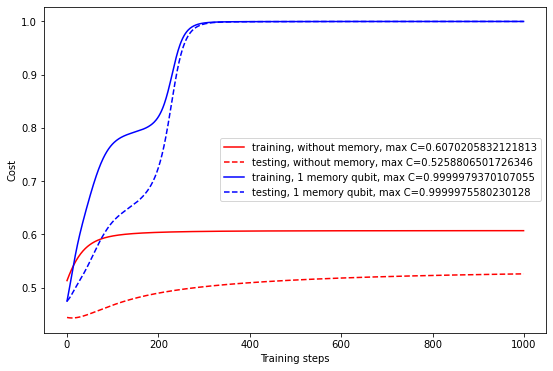

In [18]:
def comparisonplotsforswapwith1memqubit (qnnarchwom,learningrate, epsilon, numbertrainingsteps,N):
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    s=[]
    Cwom=[]
    C1m=[]
    Cwomtest=[]
    C1mtest=[]
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    trainingset1m=trainingsetfromswapwithonememqubit (N)
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    trainingset1mtest=trainingsetfromswapwithonememqubit (N)
    trainingsetwomtest=trainingset1mtest.copy()
    trainingsetwomtest.pop(0)
    for i in range(numbertrainingsteps):
        #feedforward and backward part first wom and then with 1 mem qubit
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        rhowomtest=feedforwardwom(trainingsetwomtest,unitarieswom,qnnarchwom)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        rho1mtest=feedforward(trainingset1mtest,unitaries1m,qnnarch1m)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        #lists for plot
        s.append(i*epsilon)
        Cwom.append(costwom(trainingsetwom,rhowom))
        C1m.append(cost(trainingset1m,rho1m))
        Cwomtest.append(costwom(trainingsetwomtest,rhowomtest))
        C1mtest.append(cost(trainingset1mtest,rho1mtest))
        #calculate update matrices
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
    Cwommax=max(Cwom)
    C1mmax=max(C1m)
    Cwommaxtest=max(Cwomtest)
    C1mmaxtest=max(C1mtest)
    #plot
    plt.plot(s,Cwom,'r',label="training, without memory, max C="+str(Cwommax))
    plt.plot(s,Cwomtest,'r--',label="testing, without memory, max C="+str(Cwommaxtest))
    plt.plot(s,C1m,'b',label="training, 1 memory qubit, max C="+str(C1mmax))
    plt.plot(s,C1mtest,'b--',label="testing, 1 memory qubit, max C="+str(C1mmaxtest))
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    titleplot="eta*epsilon="+str(learningrate*epsilon)+" N="+str(N)+"qnnarchwom="+str(qnnarchwom)
    #plt.title(titleplot )
    plt.legend(loc="best")
    plt.show()
comparisonplotsforswapwith1memqubit ([1,1],0.06, 1, 1000,20)

#### Different architectures

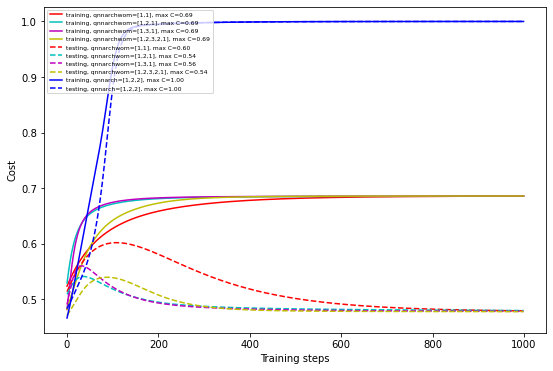

In [25]:
def comparisonplotsforswapwith1memqubitdifferentqnnarchswom (learningrate, epsilon, numbertrainingsteps,N):
    qnnarchwom1=[1,1]
    qnnarchwom2=[1,2,1]
    qnnarchwom3=[1,3,1]
    qnnarchwom4=[1,2,3,2,1]
    #namefile="C(s) with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom1="+str(qnnarchwom1)+",qnnarchwom2="+str(qnnarchwom2)+",qnnarchwom3="+str(qnnarchwom3)+",qnnarchwom4="+str(qnnarchwom4)+",numberoftrainingsteps="+str(numbertrainingsteps)+",N="+str(N)
    qnnarch1m=qnnarchwom1.copy()
    qnnarch1m[0]=qnnarchwom1[0]+1
    qnnarch1m[-1]=qnnarchwom1[-1]+1
    qnnarch1m.insert(0,1)
    s=[]
    Cwom1=[]
    Cwomtest1=[]
    Cwom2=[]
    Cwomtest2=[]
    Cwom3=[]
    Cwomtest3=[]
    Cwom4=[]
    Cwomtest4=[]
    C1m=[]
    C1mtest=[]
    #dC=pd.DataFrame(data=None,index=None,columns=["step","Cwom1","Cwom2","Cwom3","Cwom4","C1m","Cwomtest1","Cwomtest2","Cwomtest3","Cwomtest4","C1mtest"])
    L1=len(qnnarchwom1)-1
    L2=len(qnnarchwom2)-1
    L3=len(qnnarchwom3)-1
    L4=len(qnnarchwom4)-1
    unitarieswom1=randomunitarieswom(qnnarchwom1)
    unitarieswom2=randomunitarieswom(qnnarchwom2)
    unitarieswom3=randomunitarieswom(qnnarchwom3)
    unitarieswom4=randomunitarieswom(qnnarchwom4)
    unitaries1m=randomunitaries(qnnarch1m)
    trainingset1m=trainingsetfromswapwithonememqubit (N)
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    trainingset1mtest=trainingsetfromswapwithonememqubit (N)
    trainingsetwomtest=trainingset1mtest.copy()
    trainingsetwomtest.pop(0)
    for i in range(numbertrainingsteps):
        #feedforward and backward part first wom and then with 1 mem qubit
        rhowom1=feedforwardwom(trainingsetwom,unitarieswom1,qnnarchwom1)
        rhowomtest1=feedforwardwom(trainingsetwomtest,unitarieswom1,qnnarchwom1)
        sigmawom1=backwardwom(trainingsetwom, unitarieswom1, qnnarchwom1)
        rhowom2=feedforwardwom(trainingsetwom,unitarieswom2,qnnarchwom2)
        rhowomtest2=feedforwardwom(trainingsetwomtest,unitarieswom2,qnnarchwom2)
        sigmawom2=backwardwom(trainingsetwom, unitarieswom2, qnnarchwom2)
        rhowom3=feedforwardwom(trainingsetwom,unitarieswom3,qnnarchwom3)
        rhowomtest3=feedforwardwom(trainingsetwomtest,unitarieswom3,qnnarchwom3)
        sigmawom3=backwardwom(trainingsetwom, unitarieswom3, qnnarchwom3)
        rhowom4=feedforwardwom(trainingsetwom,unitarieswom4,qnnarchwom4)
        rhowomtest4=feedforwardwom(trainingsetwomtest,unitarieswom4,qnnarchwom4)
        sigmawom4=backwardwom(trainingsetwom, unitarieswom4, qnnarchwom4)
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        rho1mtest=feedforward(trainingset1mtest,unitaries1m,qnnarch1m)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        #lists for plot
        s.append(i)
        Cwom1i=costwom(trainingsetwom,rhowom1)
        Cwom1.append(Cwom1i)
        Cwom2i=costwom(trainingsetwom,rhowom2)
        Cwom2.append(Cwom2i)
        Cwom3i=costwom(trainingsetwom,rhowom3)
        Cwom3.append(Cwom3i)
        Cwom4i=costwom(trainingsetwom,rhowom4)
        Cwom4.append(Cwom4i)
        C1mi=cost(trainingset1m,rho1m)
        C1m.append(C1mi)
        Cwomtest1i=costwom(trainingsetwomtest,rhowomtest1)
        Cwomtest1.append(Cwomtest1i)
        Cwomtest2i=costwom(trainingsetwomtest,rhowomtest2)
        Cwomtest2.append(Cwomtest2i)
        Cwomtest3i=costwom(trainingsetwomtest,rhowomtest3)
        Cwomtest3.append(Cwomtest3i)
        Cwomtest4i=costwom(trainingsetwomtest,rhowomtest4)
        Cwomtest4.append(Cwomtest4i)
        C1mtesti=cost(trainingset1mtest,rho1mtest)
        C1mtest.append(C1mtesti)
        #dC=dC.append(pd.DataFrame([[i,Cwom1i,Cwom2i,Cwom3i,Cwom4i,C1mi,Cwomtest1i,Cwomtest2i,Cwomtest3i,Cwomtest4i,C1mtesti]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefile)
        #calculate update matrices
        updateunitswom1=updatematriceswom(unitarieswom1, trainingsetwom, qnnarchwom1,rhowom1,sigmawom1,learningrate,epsilon)
        updateunitswom2=updatematriceswom(unitarieswom2, trainingsetwom, qnnarchwom2,rhowom2,sigmawom2,learningrate,epsilon)
        updateunitswom3=updatematriceswom(unitarieswom3, trainingsetwom, qnnarchwom3,rhowom3,sigmawom3,learningrate,epsilon)
        updateunitswom4=updatematriceswom(unitarieswom4, trainingsetwom, qnnarchwom4,rhowom4,sigmawom4,learningrate,epsilon)
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        #update unitaries
        for l in range(L1):
            for j in range(qnnarchwom1[l+1]):
                unitarieswom1[l][j]=updateunitswom1[l][j]*unitarieswom1[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
        for l in range(L2):
            for j in range(qnnarchwom2[l+1]):
                unitarieswom2[l][j]=updateunitswom2[l][j]*unitarieswom2[l][j]
        for l in range(L3):
            for j in range(qnnarchwom3[l+1]):
                unitarieswom3[l][j]=updateunitswom3[l][j]*unitarieswom3[l][j]
        for l in range(L4):
            for j in range(qnnarchwom4[l+1]):
                unitarieswom4[l][j]=updateunitswom4[l][j]*unitarieswom4[l][j]
    Cwom1max=max(Cwom1)
    Cwom2max=max(Cwom2)
    Cwom3max=max(Cwom3)
    Cwom4max=max(Cwom4)
    C1mmax=max(C1m)
    Cwom1maxtest=max(Cwomtest1)
    Cwom2maxtest=max(Cwomtest2)
    Cwom3maxtest=max(Cwomtest3)
    Cwom4maxtest=max(Cwomtest4)
    C1mmaxtest=max(C1mtest)
    #plot
    plt.plot(s,Cwom1,'r',label="training, qnnarchwom=[1,1], max C=%.2f" %Cwom1max)
    plt.plot(s,Cwom2,'c',label="training, qnnarchwom=[1,2,1], max C=%.2f" %Cwom2max)
    plt.plot(s,Cwom3,'m',label="training, qnnarchwom=[1,3,1], max C=%.2f" %Cwom3max)
    plt.plot(s,Cwom4,'y',label="training, qnnarchwom=[1,2,3,2,1], max C=%.2f" %Cwom4max)
    plt.plot(s,Cwomtest1,'r--',label="testing, qnnarchwom=[1,1], max C=%.2f" %Cwom1maxtest)
    plt.plot(s,Cwomtest2,'c--',label="testing, qnnarchwom=[1,2,1], max C=%.2f" %Cwom2maxtest)
    plt.plot(s,Cwomtest3,'m--',label="testing, qnnarchwom=[1,3,1], max C=%.2f" %Cwom3maxtest)
    plt.plot(s,Cwomtest4,'y--',label="testing, qnnarchwom=[1,2,3,2,1], max C=%.2f" %Cwom4maxtest)
    plt.plot(s,C1m,'b',label="training, qnnarch=[1,2,2], max C=%.2f" %C1mmax)
    plt.plot(s,C1mtest,'b--',label="testing, qnnarch=[1,2,2], max C=%.2f" %C1mmaxtest)
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    plt.legend(loc="best",prop={'size':6})
    plt.show()
comparisonplotsforswapwith1memqubitdifferentqnnarchswom (0.06, 1, 1000,20)

#### Generalisation behaviour


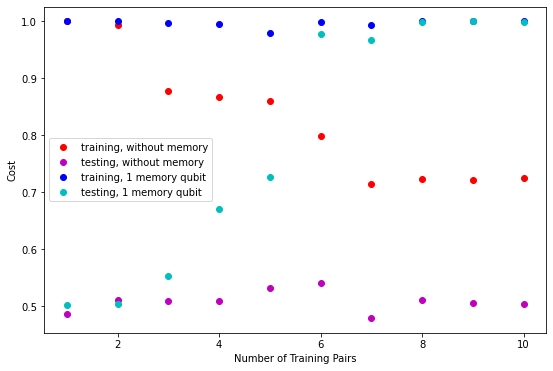

In [24]:
def generalisationbehaviourSWAP1m(Ntest,Nmax,averageover,qnnarchwom,learningrate, epsilon, numbertrainingsteps):
    Numbertrainingpairs=[]
    Cwom=[]
    C1m=[]
    Cwomtest=[]
    C1mtest=[]
    #dC=pd.DataFrame(data=None,index=None,columns=["N","Cwom","C1m","Cwomtest","C1mtest"])
    #namefile="Generalisationbehaviour Ctest with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",Nmax="+str(Nmax)+",Ntest="+str(Ntest)+",averaged over"+str(averageover)
    L=len(qnnarchwom)-1
    for N in range(1,Nmax+1):
        Numbertrainingpairs.append(N)
        Cwomiaverage=0
        C1miaverage=0
        Cwomtestiaverage=0
        C1mtestiaverage=0
        for y in range(averageover):
            trainingset1m=trainingsetfromswapwithonememqubit (N)
            trainingsetwom=trainingset1m.copy()
            trainingsetwom.pop(0)
            trainingset1mtest=trainingsetfromswapwithonememqubit (Ntest)
            trainingsetwomtest=trainingset1mtest.copy()
            trainingsetwomtest.pop(0)
            qnnarch1m=qnnarchwom.copy()
            qnnarch1m[0]=qnnarchwom[0]+1
            qnnarch1m[-1]=qnnarchwom[-1]+1
            qnnarch1m.insert(0,1)
            unitarieswom=randomunitarieswom(qnnarchwom)
            unitaries1m=randomunitaries(qnnarch1m)
            for i in range(numbertrainingsteps):
                #feedforward and backward part first wom and then with 1 mem qubit
                rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
                sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
                rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
                omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
                #calculate update matrices
                updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
                updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
                #update unitaries
                for l in range(L):
                    for j in range(qnnarchwom[l+1]):
                        unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
                        for j in range(qnnarch1m[l+2]):
                            unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
            rhowomtest=feedforwardwom(trainingsetwomtest,unitarieswom,qnnarchwom)
            rho1mtest=feedforward(trainingset1mtest,unitaries1m,qnnarch1m)
            Cwomi=costwom(trainingsetwom,rhowom)
            C1mi=cost(trainingset1m,rho1m)
            Cwomtesti=costwom(trainingsetwomtest,rhowomtest)
            C1mtesti=cost(trainingset1mtest,rho1mtest)
            Cwomiaverage=Cwomiaverage+Cwomi/averageover
            C1miaverage=C1miaverage+C1mi/averageover
            Cwomtestiaverage=Cwomtestiaverage+Cwomtesti/averageover
            C1mtestiaverage=C1mtestiaverage+C1mtesti/averageover
        #dC=dC.append(pd.DataFrame([[N,Cwomiaverage,C1miaverage,Cwomtestiaverage,C1mtestiaverage]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefile)
        Cwom.append(Cwomiaverage)
        C1m.append(C1miaverage)
        Cwomtest.append(Cwomtestiaverage)
        C1mtest.append(C1mtestiaverage)
    plt.plot(Numbertrainingpairs,Cwom,'ro',label="training, without memory")
    plt.plot(Numbertrainingpairs,Cwomtest,'mo',label="testing, without memory")
    plt.plot(Numbertrainingpairs,C1m,'bo',label="training, 1 memory qubit")
    plt.plot(Numbertrainingpairs,C1mtest,'co',label="testing, 1 memory qubit")
    plt.xlabel('Number of Training Pairs')
    plt.ylabel('Cost')
    plt.legend(loc="best")
    plt.show()
generalisationbehaviourSWAP1m(20,10,10,[1,1],0.06, 1, 1000)

### SWAP with 2 memory qubits

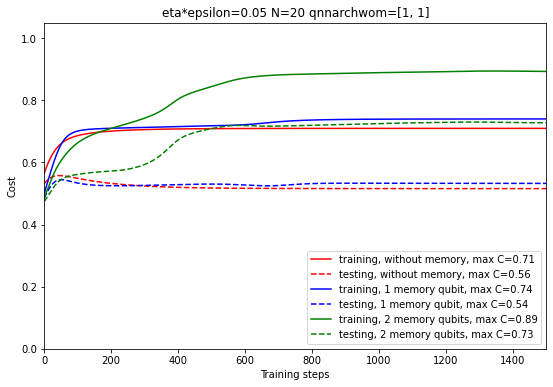

In [30]:
def comparisonplotsforswapwith2memqubit (qnnarchwom,learningrate, epsilon, numbertrainingsteps,N):
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    qnnarch2m=qnnarch1m.copy()
    qnnarch2m[0]=2
    qnnarch2m[1]=qnnarch1m[1]+1
    qnnarch2m[-1]=qnnarch1m[-1]+1
    s=[]
    Cwom=[]
    C1m=[]
    C2m=[]
    Cwomtest=[]
    C1mtest=[]
    C2mtest=[]
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    unitaries2m=randomunitaries(qnnarch2m)
    trainingset2m=trainingsetfromswapwithtwomemqubit (N)
    trainingset1m=trainingset2m.copy()
    trainingset1m[0]=qt.ket2dm(qt.basis(2,0))
    trainingsetwom=trainingset2m.copy()
    trainingsetwom.pop(0)
    trainingset2mtest=trainingsetfromswapwithtwomemqubit (N)
    trainingset1mtest=trainingset2mtest.copy()
    trainingset1mtest[0]=qt.ket2dm(qt.basis(2,0))
    trainingsetwomtest=trainingset2mtest.copy()
    trainingsetwomtest.pop(0)
    for i in range(numbertrainingsteps):
        #feedforward and backward part first wom and then with 1 mem qubit
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        rhowomtest=feedforwardwom(trainingsetwomtest,unitarieswom,qnnarchwom)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        rho1mtest=feedforward(trainingset1mtest,unitaries1m,qnnarch1m)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        rho2m=feedforward(trainingset2m,unitaries2m,qnnarch2m)
        rho2mtest=feedforward(trainingset2mtest,unitaries2m,qnnarch2m)
        omega2m=backward(trainingset2m, unitaries2m, qnnarch2m)
        #lists for plot
        s.append(i*epsilon)
        Cwom.append(costwom(trainingsetwom,rhowom))
        C1m.append(cost(trainingset1m,rho1m))
        C2m.append(cost(trainingset2m,rho2m))
        Cwomtest.append(costwom(trainingsetwomtest,rhowomtest))
        C1mtest.append(cost(trainingset1mtest,rho1mtest))
        C2mtest.append(cost(trainingset2mtest,rho2mtest))
        #calculate update matrices
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        updateunits2m=updatematrices(unitaries2m, trainingset2m, qnnarch2m,rho2m,omega2m,learningrate,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
            for j in range(qnnarch2m[l+2]):
                unitaries2m[l][j]=updateunits2m[l][j]*unitaries2m[l][j]
    Cwommax=max(Cwom)
    C1mmax=max(C1m)
    C2mmax=max(C2m)
    Cwommaxtest=max(Cwomtest)
    C1mmaxtest=max(C1mtest)
    C2mmaxtest=max(C2mtest)
    #plot
    plt.plot(s,Cwom,'r',label="training, without memory, max C=%.2f" %Cwommax)
    plt.plot(s,Cwomtest,'r--',label="testing, without memory, max C=%.2f" %Cwommaxtest)
    plt.plot(s,C1m,'b',label="training, 1 memory qubit, max C=%.2f" %C1mmax)
    plt.plot(s,C1mtest,'b--',label="testing, 1 memory qubit, max C=%.2f" %C1mmaxtest)
    plt.plot(s,C2m,'g',label="training, 2 memory qubits, max C=%.2f" %C2mmax)
    plt.plot(s,C2mtest,'g--',label="testing, 2 memory qubits, max C=%.2f" %C2mmaxtest)
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    plt.axis([0,numbertrainingsteps,0,1.05])
    titleplot="eta*epsilon="+str(learningrate*epsilon)+" N="+str(N)+" qnnarchwom="+str(qnnarchwom)
    plt.title(titleplot )
    plt.legend(loc="lower right",prop={'size':10})
    plt.show()
comparisonplotsforswapwith2memqubit ([1,1],0.05, 1, 1500,20)

### SWAP with 3 memory qubits

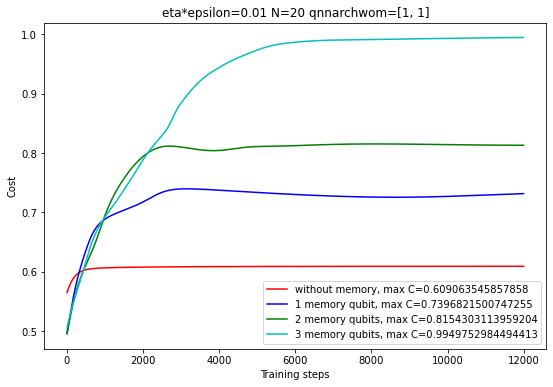

In [16]:
def comparisonplotsforswapwith3memqubit (qnnarchwom,learningrate, epsilon, numbertrainingsteps,N):
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    qnnarch2m=qnnarch1m.copy()
    qnnarch2m[0]=2
    qnnarch2m[1]=qnnarch1m[1]+1
    qnnarch2m[-1]=qnnarch1m[-1]+1
    qnnarch3m=qnnarch2m.copy()
    qnnarch3m[0]=3
    qnnarch3m[1]=qnnarch2m[1]+1
    qnnarch3m[-1]=qnnarch2m[-1]+1
    s=[]
    Cwom=[]
    C1m=[]
    C2m=[]
    C3m=[]
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    unitaries2m=randomunitaries(qnnarch2m)
    unitaries3m=randomunitaries(qnnarch3m)
    trainingset3m=trainingsetfromswapwiththreememqubit (N)
    trainingset2m=trainingset3m.copy()
    trainingset2m[0]=qt.tensor(qt.ket2dm(qt.basis(2,0)),qt.ket2dm(qt.basis(2,0)))
    trainingset1m=trainingset2m.copy()
    trainingset1m[0]=qt.ket2dm(qt.basis(2,0))
    trainingsetwom=trainingset3m.copy()
    trainingsetwom.pop(0)
    for i in range(numbertrainingsteps):
        #feedforward and backward part first wom and then with 1 mem qubit
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        rho2m=feedforward(trainingset2m,unitaries2m,qnnarch2m)
        omega2m=backward(trainingset2m, unitaries2m, qnnarch2m)
        rho3m=feedforward(trainingset3m,unitaries3m,qnnarch3m)
        omega3m=backward(trainingset3m, unitaries3m, qnnarch3m)
        #lists for plot
        s.append(i)
        Cwom.append(costwom(trainingsetwom,rhowom))
        C1m.append(cost(trainingset1m,rho1m))
        C2m.append(cost(trainingset2m,rho2m))
        C3m.append(cost(trainingset3m,rho3m))
        #calculate update matrices
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        updateunits2m=updatematrices(unitaries2m, trainingset2m, qnnarch2m,rho2m,omega2m,learningrate,epsilon)
        updateunits3m=updatematrices(unitaries3m, trainingset3m, qnnarch3m,rho3m,omega3m,learningrate,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
            for j in range(qnnarch2m[l+2]):
                unitaries2m[l][j]=updateunits2m[l][j]*unitaries2m[l][j]
            for j in range(qnnarch3m[l+2]):
                unitaries3m[l][j]=updateunits3m[l][j]*unitaries3m[l][j]
    Cwommax=max(Cwom)
    C1mmax=max(C1m)
    C2mmax=max(C2m)
    C3mmax=max(C3m)
    #plot
    plt.plot(s,Cwom,'r',label="without memory, max C="+str(Cwommax))
    plt.plot(s,C1m,'b',label="1 memory qubit, max C="+str(C1mmax))
    plt.plot(s,C2m,'g',label="2 memory qubits, max C="+str(C2mmax))
    plt.plot(s,C3m,'c',label="3 memory qubits, max C="+str(C3mmax))
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    titleplot="eta*epsilon="+str(learningrate*epsilon)+" N="+str(N)+" qnnarchwom="+str(qnnarchwom)
    plt.title(titleplot )
    plt.legend(loc="best")
    plt.show()
comparisonplotsforswapwith3memqubit ([1,1],0.01, 1, 12000,20)

### Time series prediction



#### Flip


C:\Users\vssch\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\vssch\AppData\Local\Temp/ipykernel_22668/758222934.py:124: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_22668/758222934.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_22668/758222934.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


0

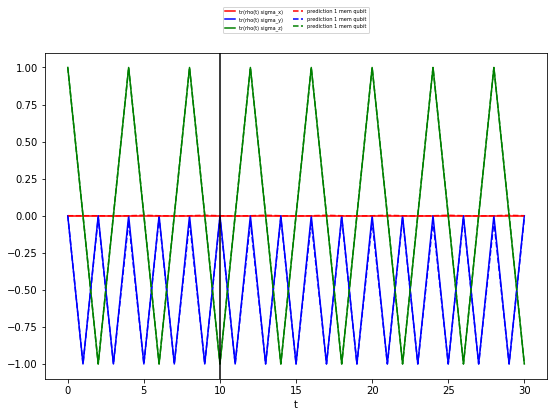

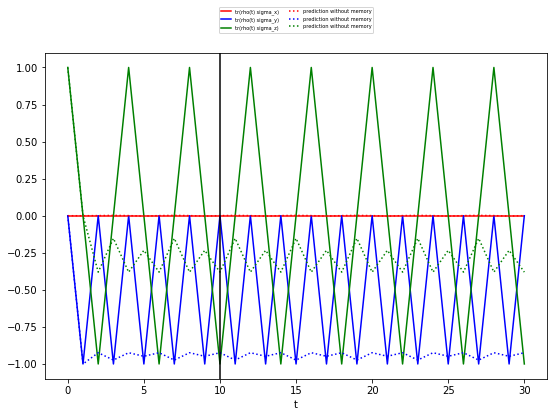

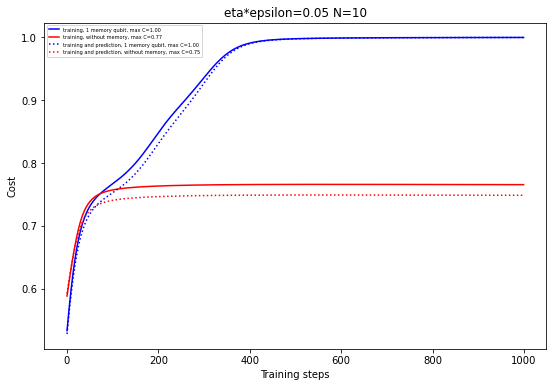

In [29]:
def timedependenthamiltoniantask1qubitBlochcomparisonspecialcase (Ntraining,Nprediction,tau,learningrate,epsilon, numbertrainingsteps,qnnarchwom):
    psi0=qt.basis(2,0)
    t=[i*tau for i in range(Ntraining+Nprediction+2)]
    U1=qt.sigmax()
    U2=U1.sqrtm()
    psioft=[]
    #psiofttest=[]
    a=0
    #dC=pd.DataFrame(data=None,index=None,columns=["step","Cwomtraining","C1mtraining","Cwomtrainingprediction","C1mtrainingprediction"])
    #namefileC="C sigmaxflip with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",Ntraining="+str(Ntraining)+",Nprediction="+str(Nprediction)
    #dB=pd.DataFrame(data=None,index=None,columns=["t","x","y","z","xwom","ywom","zwom","x1m","y1m","z1m"])
    #namefileB="Bloch coordinates sigmaxflip with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",Ntraining="+str(Ntraining)+",Nprediction="+str(Nprediction)
    while a<=(Ntraining+Nprediction+3)/4:
        a=a+1
        psioft.append(psi0)
        psioft.append(U2*psi0)
        psioft.append(U1*psi0)
        psioft.append(U2*psi0)
    trainingset1m=[qt.ket2dm(psioft[0])]
    for i in range(1,Ntraining+1):
        trainingseti=[qt.ket2dm(psioft[i]),psioft[i+1]]
        trainingset1m.append(trainingseti)
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    completeset1m=[qt.ket2dm(psioft[0])]
    for i in range(1,Ntraining+Nprediction+1):
        completeseti=[qt.ket2dm(psioft[i]),psioft[i+1]]
        completeset1m.append(completeseti)
    completesetwom=completeset1m.copy()
    completesetwom.pop(0)
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    s=[]
    C1mtraining=[]
    C1mtrainingprediction=[]
    Cwomtraining=[]
    Cwomtrainingprediction=[]
    for i in range(numbertrainingsteps):
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        rho1mprediction=feedforward(completeset1m,unitaries1m,qnnarch1m)
        rhowomprediction=feedforwardwom(completesetwom,unitarieswom,qnnarchwom)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        s.append(i*epsilon)
        Cwomtrainingi=cost(trainingsetwom,rhowom)
        C1mtrainingi=cost(trainingset1m,rho1m)
        Cwomtrainingpredictioni=cost(completesetwom,rhowomprediction)
        C1mtrainingpredictioni=cost(completeset1m,rho1mprediction)
        C1mtraining.append(C1mtrainingi)
        Cwomtraining.append(Cwomtrainingi)
        C1mtrainingprediction.append(C1mtrainingpredictioni)
        Cwomtrainingprediction.append(Cwomtrainingpredictioni)
        #dC=dC.append(pd.DataFrame([[i,Cwomtrainingi,C1mtrainingi,Cwomtrainingpredictioni,C1mtrainingpredictioni]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefileC)
        #calculate update matrices
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
    rhopredict1m=[qt.ket2dm(psioft[0]),qt.ket2dm(psioft[1])]
    rhopredictwom=[qt.ket2dm(psioft[0]),qt.ket2dm(psioft[1])]
    rhopredicttotal1m=feedforward(completeset1m,unitaries1m,qnnarch1m)
    rhopredicttotalwom=feedforwardwom(completesetwom,unitarieswom,qnnarchwom)
    for i in range(Ntraining+Nprediction):
        rhopredict1m.append(rhopredicttotal1m[i][-1])
        rhopredictwom.append(rhopredicttotalwom[i][-1])
    rhotrue=[]
    for i in range(len(psioft)):
        rhotrue.append(qt.ket2dm(psioft[i]))
    t=[]
    xtrue=[]
    ytrue=[]
    ztrue=[]
    xpredict1m=[]
    ypredict1m=[]
    zpredict1m=[]
    xpredictwom=[]
    ypredictwom=[]
    zpredictwom=[]
    for i in range(Ntraining+Nprediction+1):
        t.append(i*tau)
        xtruei=(rhotrue[i]*qt.sigmax()).tr()
        xtrue.append(xtruei)
        ytruei=(rhotrue[i]*qt.sigmay()).tr()
        ytrue.append(ytruei)
        ztruei=(rhotrue[i]*qt.sigmaz()).tr()
        ztrue.append(ztruei)
        xpredict1mi=(rhopredict1m[i]*qt.sigmax()).tr()
        xpredict1m.append(xpredict1mi)
        ypredict1mi=(rhopredict1m[i]*qt.sigmay()).tr()
        ypredict1m.append(ypredict1mi)
        zpredict1mi=(rhopredict1m[i]*qt.sigmaz()).tr()
        zpredict1m.append(zpredict1mi)
        xpredictwomi=(rhopredictwom[i]*qt.sigmax()).tr()
        xpredictwom.append(xpredictwomi)
        ypredictwomi=(rhopredictwom[i]*qt.sigmay()).tr()
        ypredictwom.append(ypredictwomi)
        zpredictwomi=(rhopredictwom[i]*qt.sigmaz()).tr()
        zpredictwom.append(zpredictwomi)
        #dB=dB.append(pd.DataFrame([[i*tau,xtruei,ytruei,ztruei,xpredictwomi,ypredictwomi,zpredictwomi,xpredict1mi,ypredict1mi,zpredict1mi]],columns=dB.columns),ignore_index=True)
        #dB.to_csv("%s.csv" % namefileB)
    fig1=plt.figure()
    plt.plot(t,xtrue,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytrue,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztrue,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredict1m,'r--',label="prediction 1 mem qubit")
    plt.plot(t,ypredict1m,'b--',label="prediction 1 mem qubit")
    plt.plot(t,zpredict1m,'g--',label="prediction 1 mem qubit")
    plt.xlabel('t')
    plt.ylabel('')
    plt.axvline(x=tau*Ntraining,color='k')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    #namefile="Bloch vector coordinates (t) sigmaxflip 1mem  etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+" Ntraining="+str(Ntraining)+" Nprediction="+str(Nprediction)+" tau="+str(tau)+" sigmaxflip"
    fig1.show()
    fig2=plt.figure()
    plt.plot(t,xtrue,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytrue,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztrue,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredictwom,'r:',label="prediction without memory")
    plt.plot(t,ypredictwom,'b:',label="prediction without memory")
    plt.plot(t,zpredictwom,'g:',label="prediction without memory")
    plt.xlabel('t')
    plt.ylabel('')
    plt.axvline(x=tau*Ntraining,color='k')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    #namefile="Bloch vector coordinates (t) sigmaxflip wom with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+" Ntraining="+str(Ntraining)+" Nprediction="+str(Nprediction)+" tau="+str(tau)+" sigmaxflip"
    fig2.show()
    fig3=plt.figure()
    C1mtrainingmax=max(C1mtraining)
    Cwomtrainingmax=max(Cwomtraining)
    C1mtrainingpredictionmax=max(C1mtrainingprediction)
    Cwomtrainingpredictionmax=max(Cwomtrainingprediction)
    plt.plot(s,C1mtraining,'b',label="training, 1 memory qubit, max C=%.2f" %C1mtrainingmax)
    plt.plot(s,Cwomtraining,'r',label="training, without memory, max C=%.2f" %Cwomtrainingmax)
    plt.plot(s,C1mtrainingprediction,'b:',label="training and prediction, 1 memory qubit, max C=%.2f" %C1mtrainingpredictionmax)
    plt.plot(s,Cwomtrainingprediction,'r:',label="training and prediction, without memory, max C=%.2f" %Cwomtrainingpredictionmax)
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    titleplot="eta*epsilon="+str(learningrate*epsilon)+" N="+str(Ntraining)
    plt.title(titleplot )
    plt.legend(loc="best",prop={'size':5})
    #namefile="C(s) sigmaxflip with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",Ntraining="+str(Ntraining)+",Nprediction="+str(Nprediction)+" sigmaxflip"
    fig3.show()
    return 0
timedependenthamiltoniantask1qubitBlochcomparisonspecialcase (10,20,1,0.05,1, 1000,[1,2,1])

### Time evolution governed by $H(t)=\frac{1}{2}f(t)(1-\sigma^x)$ with $$f(t)=\begin{cases}
			\begin{aligned}
				&1 &&,t\in [2k,2k+1)\\
				&-1 &&,t\in [2k+1,2k)
			\end{aligned}
		\end{cases},\ k\in \mathbb{N}$$

C:\Users\vssch\AppData\Local\Temp/ipykernel_27404/528205281.py:162: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_27404/528205281.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_27404/528205281.py:193: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_27404/528205281.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()
C:\Users\vssch\AppData\Local\Temp/ipykernel_27404/528205281.py:216: UserWarning: Matplotlib is currently usi

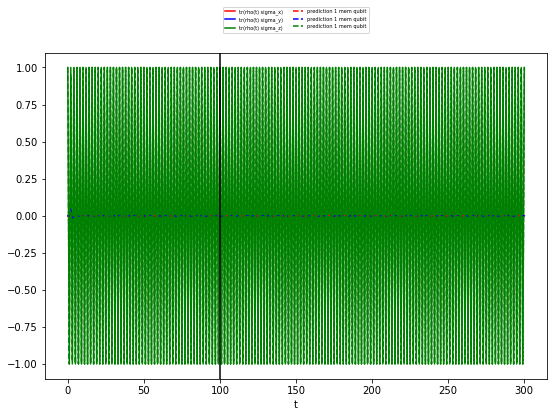

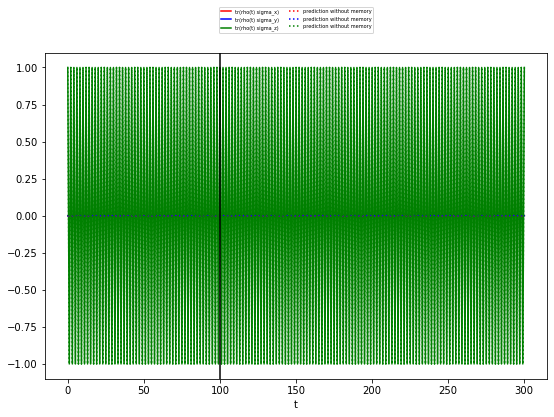

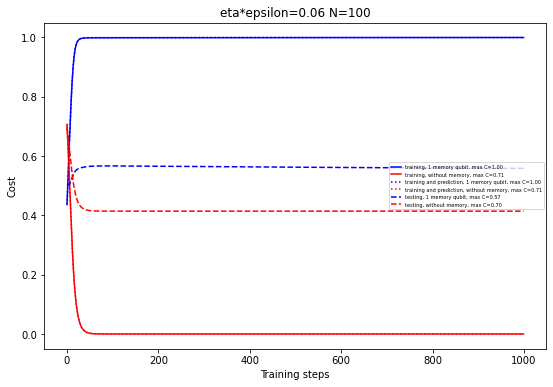

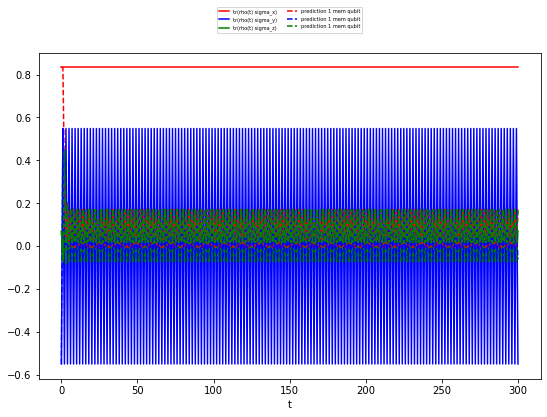

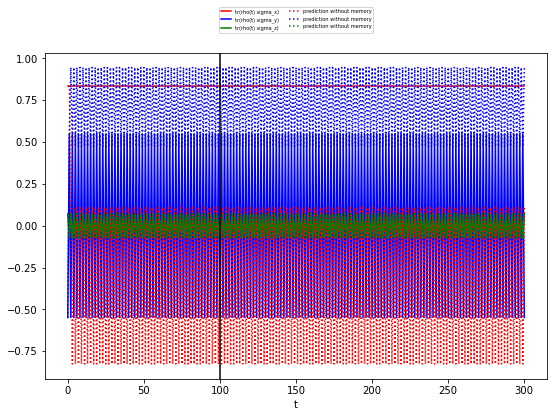

In [28]:
def timedependenthamiltoniantask1qubitBlochcomparison (Ntraining,Nprediction,tau,learningrate,epsilon, numbertrainingsteps,qnnarchwom,H,Htext):
    #namefile="C(s) with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",Ntraining="+str(Ntraining)+",Nprediction="+str(Nprediction)+",H="+Htext
    psi0=qt.basis(2,0)
    psi0test=randomstate(1)
    t=[i*tau for i in range(Ntraining+Nprediction+2)]
    result=qt.mesolve(H,psi0,t,[],[])
    resulttest=qt.mesolve(H,psi0test,t,[],[])
    psioft=result.states
    psiofttest=resulttest.states
    trainingset1m=[qt.ket2dm(psioft[0])]
    for i in range(1,Ntraining+1):
        trainingseti=[qt.ket2dm(psioft[i]),psioft[i+1]]
        trainingset1m.append(trainingseti)
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    completeset1m=[qt.ket2dm(psioft[0])]
    for i in range(1,Ntraining+Nprediction+1):
        completeseti=[qt.ket2dm(psioft[i]),psioft[i+1]]
        completeset1m.append(completeseti)
    completesetwom=completeset1m.copy()
    completesetwom.pop(0)
    completeset1mtest=[qt.ket2dm(psiofttest[0])]
    for i in range(1,Ntraining+Nprediction+1):
        completesettesti=[qt.ket2dm(psiofttest[i]),psiofttest[i+1]]
        completeset1mtest.append(completesettesti)
    completesetwomtest=completeset1mtest.copy()
    completesetwomtest.pop(0)
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    s=[]
    C1mtraining=[]
    C1mtrainingprediction=[]
    C1mtest=[]
    Cwomtraining=[]
    Cwomtrainingprediction=[]
    Cwomtest=[]
    #dC=pd.DataFrame(data=None,index=None,columns=["step","C1mtraining","C1mtrainingprediction","C1mtest","Cwomtraining","Cwomtrainingprediction","Cwomtest"])
    for i in range(numbertrainingsteps):
        rho1m=feedforward(trainingset1m,unitaries1m,qnnarch1m)
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        rho1mprediction=feedforward(completeset1m,unitaries1m,qnnarch1m)
        rhowomprediction=feedforwardwom(completesetwom,unitarieswom,qnnarchwom)
        rho1mtest=feedforward(completeset1mtest,unitaries1m,qnnarch1m)
        rhowomtest=feedforwardwom(completesetwomtest,unitarieswom,qnnarchwom)
        omega1m=backward(trainingset1m, unitaries1m, qnnarch1m)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        s.append(i*epsilon)
        C1mtrainingi=cost(trainingset1m,rho1m)
        C1mtraining.append(C1mtrainingi)
        Cwomtrainingi=cost(trainingsetwom,rhowom)
        Cwomtraining.append(Cwomtrainingi)
        C1mtrainingpredictioni=cost(completeset1m,rho1mprediction)
        C1mtrainingprediction.append(C1mtrainingpredictioni)
        Cwomtrainingpredictioni=cost(completesetwom,rhowomprediction)
        Cwomtrainingprediction.append(Cwomtrainingpredictioni)
        C1mtesti=cost(completeset1mtest,rho1mtest)
        C1mtest.append(C1mtesti)
        Cwomtesti=cost(completesetwomtest,rhowomtest)
        Cwomtest.append(Cwomtesti)
        #dC=dC.append(pd.DataFrame([[i,C1mtrainingi,C1mtrainingpredictioni,C1mtesti,Cwomtrainingi,Cwomtrainingpredictioni,Cwomtesti]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefile)
        #calculate update matrices
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
    rhopredict1m=[qt.ket2dm(psioft[0]),qt.ket2dm(psioft[1])]
    rhopredictwom=[qt.ket2dm(psioft[0]),qt.ket2dm(psioft[1])]
    rhopredict1mtest=[qt.ket2dm(psiofttest[0]),qt.ket2dm(psiofttest[1])]
    rhopredictwomtest=[qt.ket2dm(psiofttest[0]),qt.ket2dm(psiofttest[1])]
    rhopredicttotal1m=feedforward(completeset1m,unitaries1m,qnnarch1m)
    rhopredicttotalwom=feedforwardwom(completesetwom,unitarieswom,qnnarchwom)
    rhopredicttotal1mtest=feedforward(completeset1mtest,unitaries1m,qnnarch1m)
    rhopredicttotalwomtest=feedforwardwom(completesetwomtest,unitarieswom,qnnarchwom)
    for i in range(Ntraining+Nprediction):
        rhopredict1m.append(rhopredicttotal1m[i][-1])
        rhopredictwom.append(rhopredicttotalwom[i][-1])
        rhopredict1mtest.append(rhopredicttotal1mtest[i][-1])
        rhopredictwomtest.append(rhopredicttotalwomtest[i][-1])
    rhotrue=[]
    rhotruetest=[]
    for i in range(len(psioft)):
        rhotrue.append(qt.ket2dm(psioft[i]))
        rhotruetest.append(qt.ket2dm(psiofttest[i]))
    t=[]
    xtrue=[]
    ytrue=[]
    ztrue=[]
    xpredict1m=[]
    ypredict1m=[]
    zpredict1m=[]
    xpredictwom=[]
    ypredictwom=[]
    zpredictwom=[]
    xtruetest=[]
    ytruetest=[]
    ztruetest=[]
    xpredict1mtest=[]
    ypredict1mtest=[]
    zpredict1mtest=[]
    xpredictwomtest=[]
    ypredictwomtest=[]
    zpredictwomtest=[]
    for i in range(Ntraining+Nprediction+1):
        t.append(i*tau)
        xtruei=rhotrue[i]*qt.sigmax()
        xtrue.append(xtruei.tr())
        ytruei=rhotrue[i]*qt.sigmay()
        ytrue.append(ytruei.tr())
        ztruei=rhotrue[i]*qt.sigmaz()
        ztrue.append(ztruei.tr())
        xpredict1mi=rhopredict1m[i]*qt.sigmax()
        xpredict1m.append(xpredict1mi.tr())
        ypredict1mi=rhopredict1m[i]*qt.sigmay()
        ypredict1m.append(ypredict1mi.tr())
        zpredict1mi=rhopredict1m[i]*qt.sigmaz()
        zpredict1m.append(zpredict1mi.tr())
        xpredictwomi=rhopredictwom[i]*qt.sigmax()
        xpredictwom.append(xpredictwomi.tr())
        ypredictwomi=rhopredictwom[i]*qt.sigmay()
        ypredictwom.append(ypredictwomi.tr())
        zpredictwomi=rhopredictwom[i]*qt.sigmaz()
        zpredictwom.append(zpredictwomi.tr())
        xtruetesti=rhotruetest[i]*qt.sigmax()
        xtruetest.append(xtruetesti.tr())
        ytruetesti=rhotruetest[i]*qt.sigmay()
        ytruetest.append(ytruetesti.tr())
        ztruetesti=rhotruetest[i]*qt.sigmaz()
        ztruetest.append(ztruetesti.tr())
        xpredict1mtesti=rhopredict1mtest[i]*qt.sigmax()
        xpredict1mtest.append(xpredict1mtesti.tr())
        ypredict1mtesti=rhopredict1mtest[i]*qt.sigmay()
        ypredict1mtest.append(ypredict1mtesti.tr())
        zpredict1mtesti=rhopredict1mtest[i]*qt.sigmaz()
        zpredict1mtest.append(zpredict1mtesti.tr())
        xpredictwomtesti=rhopredictwomtest[i]*qt.sigmax()
        xpredictwomtest.append(xpredictwomtesti.tr())
        ypredictwomtesti=rhopredictwomtest[i]*qt.sigmay()
        ypredictwomtest.append(ypredictwomtesti.tr())
        zpredictwomtesti=rhopredictwomtest[i]*qt.sigmaz()
        zpredictwomtest.append(zpredictwomtesti.tr())
    fig1=plt.figure()
    plt.plot(t,xtrue,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytrue,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztrue,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredict1m,'r--',label="prediction 1 mem qubit")
    plt.plot(t,ypredict1m,'b--',label="prediction 1 mem qubit")
    plt.plot(t,zpredict1m,'g--',label="prediction 1 mem qubit")
    plt.xlabel('t')
    plt.ylabel('')
    plt.axvline(x=tau*Ntraining,color='k')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    fig1.show()
    fig2=plt.figure()
    plt.plot(t,xtrue,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytrue,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztrue,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredictwom,'r:',label="prediction without memory")
    plt.plot(t,ypredictwom,'b:',label="prediction without memory")
    plt.plot(t,zpredictwom,'g:',label="prediction without memory")
    plt.xlabel('t')
    plt.ylabel('')
    plt.axvline(x=tau*Ntraining,color='k')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    fig2.show()
    fig3=plt.figure()
    C1mtrainingmax=max(C1mtraining)
    Cwomtrainingmax=max(Cwomtraining)
    C1mtestmax=max(C1mtest)
    Cwomtestmax=max(Cwomtest)
    C1mtrainingpredictionmax=max(C1mtrainingprediction)
    Cwomtrainingpredictionmax=max(Cwomtrainingprediction)
    plt.plot(s,C1mtraining,'b',label="training, 1 memory qubit, max C=%.2f" %C1mtrainingmax)
    plt.plot(s,Cwomtraining,'r',label="training, without memory, max C=%.2f" %Cwomtrainingmax)
    plt.plot(s,C1mtrainingprediction,'b:',label="training and prediction, 1 memory qubit, max C=%.2f" %C1mtrainingpredictionmax)
    plt.plot(s,Cwomtrainingprediction,'r:',label="training and prediction, without memory, max C=%.2f" %Cwomtrainingpredictionmax)
    plt.plot(s,C1mtest,'b--',label="testing, 1 memory qubit, max C=%.2f" %C1mtestmax)
    plt.plot(s,Cwomtest,'r--',label="testing, without memory, max C=%.2f" %Cwomtestmax)
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    titleplot="eta*epsilon="+str(learningrate*epsilon)+" N="+str(Ntraining)
    plt.title(titleplot )
    plt.legend(loc="best",prop={'size':5})
    fig3.show()
    fig4=plt.figure()
    plt.plot(t,xtruetest,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytruetest,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztruetest,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredict1mtest,'r--',label="prediction 1 mem qubit")
    plt.plot(t,ypredict1mtest,'b--',label="prediction 1 mem qubit")
    plt.plot(t,zpredict1mtest,'g--',label="prediction 1 mem qubit")
    plt.xlabel('t')
    plt.ylabel('')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    fig4.show()
    fig5=plt.figure()
    plt.plot(t,xtruetest,'r',label="tr(rho(t) sigma_x)")
    plt.plot(t,ytruetest,'b',label="tr(rho(t) sigma_y)")
    plt.plot(t,ztruetest,'g',label="tr(rho(t) sigma_z)")
    plt.plot(t,xpredictwomtest,'r:',label="prediction without memory")
    plt.plot(t,ypredictwomtest,'b:',label="prediction without memory")
    plt.plot(t,zpredictwomtest,'g:',label="prediction without memory")
    plt.xlabel('t')
    plt.ylabel('')
    plt.axvline(x=tau*Ntraining,color='k')
    plt.legend(loc='center', bbox_to_anchor=(0.5, 1.10), shadow=False, ncol=2,prop={'size':5})
    fig5.show()


def stepminus1(stepwidth,t,n):
    for i in range(n):
        if ((t<(2*i+1)*stepwidth) and  t>=2*i*stepwidth):
            return -1
        if ((t<2*(i+1)*stepwidth) and  t>=(2*i+1)*stepwidth):
            return 1
    print("step wrong")
    return 0
    
    
H0=np.pi*(tensoredId(1)-qt.sigmax())/2
def H0coeff(t,args):
    return stepminus1(1,t,200)
H=[H0,H0coeff]
Htext="0,5pi stepminus(1) (1-sigmax)"

timedependenthamiltoniantask1qubitBlochcomparison (100,200,1,0.06,1, 1000,[1,1],H,Htext)

## Local Cost with mixed output
### SWAP 1m



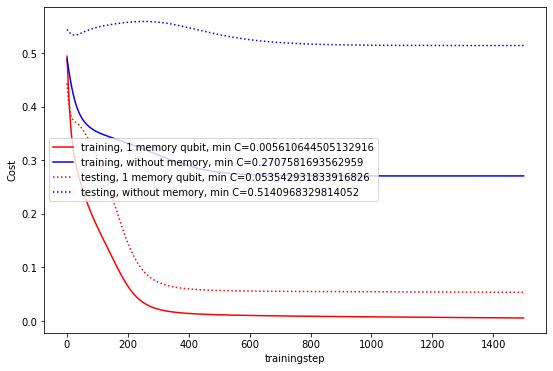

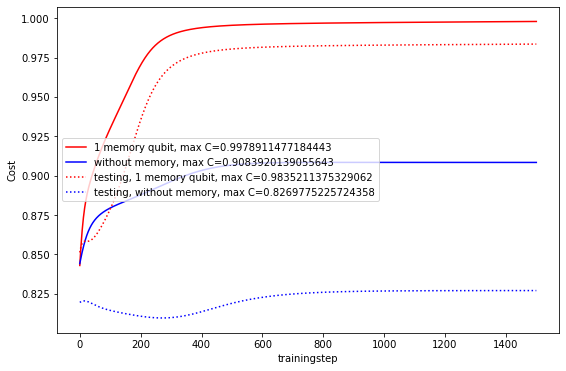

In [27]:
def learningalgorithmcostplotcomparisonwithtestset1m(trainingset1m, testset1m, qnnarchwom,learningrate, epsilon, numbertrainingsteps):
    s=[]
    Chilbert1m=[]
    Cfidelity1m=[]
    Chilbertwom=[]
    Cfidelitywom=[]
    Chilbert1mtest=[]
    Cfidelity1mtest=[]
    Chilbertwomtest=[]
    Cfidelitywomtest=[]
    L=len(qnnarchwom)-1
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    testsetwom=testset1m.copy()
    testsetwom.pop(0)
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    unitaries1m=randomunitaries(qnnarch1m)#At start, choose the unitaries randomly
    unitarieswom=randomunitarieswom(qnnarchwom)
    #namefile="mixed C SWAP1m with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",N="+str(len(trainingset1m)-1)
    #dC=pd.DataFrame(data=None,index=None,columns=["step","fidelitywom","fidelity1m","fidelitywomtest","fidelity1mtest","hilbertwom","hilbert1m","hilbertwomtest","hilbert1mtest"])
    for i in range(numbertrainingsteps):
        rhoomega1m=forwardbackwardmixed(trainingset1m, unitaries1m, qnnarch1m)
        rho1m=rhoomega1m[0]
        omega1m=rhoomega1m[1]
        rhoomegawom=forwardbackwardwommixed(trainingsetwom, unitarieswom, qnnarchwom)
        rhowom=rhoomegawom[0]
        omegawom=rhoomegawom[1]
        rhowomtest=forwardwommixed(testsetwom,unitarieswom,qnnarchwom)
        rho1mtest=forwardmixed(testset1m,unitaries1m,qnnarch1m)
        s.append(i*epsilon)
        Chilbert1mi=hilbertschmidt(trainingset1m, rho1m)
        Chilbert1m.append(Chilbert1mi)
        Cfidelity1mi=fidelity(trainingset1m, rho1m)
        Cfidelity1m.append(Cfidelity1mi)
        Chilbertwomi=hilbertschmidtwom(trainingsetwom, rhowom)
        Chilbertwom.append(Chilbertwomi)
        Cfidelitywomi=fidelitywom(trainingsetwom, rhowom)
        Cfidelitywom.append(Cfidelitywomi)
        Chilbert1mtesti=hilbertschmidt(testset1m, rho1mtest)
        Chilbert1mtest.append(Chilbert1mtesti)
        Cfidelity1mtesti=fidelity(testset1m, rho1mtest)
        Cfidelity1mtest.append(Cfidelity1mtesti)
        Chilbertwomtesti=hilbertschmidtwom(testsetwom, rhowomtest)
        Chilbertwomtest.append(Chilbertwomtesti)
        Cfidelitywomtesti=fidelitywom(testsetwom, rhowomtest)
        Cfidelitywomtest.append(Cfidelitywomtesti)
        #dC=dC.append(pd.DataFrame([[i,Cfidelitywomi,Cfidelity1mi,Cfidelitywomtesti,Cfidelity1mtesti,Chilbertwomi,Chilbert1mi,Chilbertwomtesti,Chilbert1mtesti]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefile)
        updateunits1m=updatematrices(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate,epsilon)#make updateunitaries
        updateunitswom=updatematriceswom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,omegawom,learningrate,epsilon)
        for l in range(L):
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j] #update unitaries
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
    rho1m=forwardmixed(trainingset1m, unitaries1m, qnnarch1m)
    rhowom=forwardwommixed(trainingsetwom, unitarieswom, qnnarchwom)
    rhowomtest=forwardwommixed(testsetwom,unitarieswom,qnnarchwom)
    rho1mtest=forwardmixed(testset1m,unitaries1m,qnnarch1m)
    s.append(numbertrainingsteps*epsilon)
    Chilbert1m.append(hilbertschmidt(trainingset1m, rho1m))
    Cfidelity1m.append(fidelity(trainingset1m, rho1m))
    Chilbertwom.append(hilbertschmidtwom(trainingsetwom, rhowom))
    Cfidelitywom.append(fidelitywom(trainingsetwom, rhowom))
    Chilbert1mtest.append(hilbertschmidt(testset1m, rho1mtest))
    Cfidelity1mtest.append(fidelity(testset1m, rho1mtest))
    Chilbertwomtest.append(hilbertschmidtwom(testsetwom, rhowomtest))
    Cfidelitywomtest.append(fidelitywom(testsetwom, rhowomtest))
    Chilbertmin1m=min(Chilbert1m)
    Cfidelitymax1m=max(Cfidelity1m)
    Chilbertminwom=min(Chilbertwom)
    Cfidelitymaxwom=max(Cfidelitywom)
    Chilbertmin1mtest=min(Chilbert1mtest)
    Cfidelitymax1mtest=max(Cfidelity1mtest)
    Chilbertminwomtest=min(Chilbertwomtest)
    Cfidelitymaxwomtest=max(Cfidelitywomtest)
    fig1=plt.figure()
    plt.plot(s,Chilbert1m,'r',label="training, 1 memory qubit, min C=" +str(Chilbertmin1m))
    plt.plot(s,Chilbertwom,'b',label="training, without memory, min C=" +str(Chilbertminwom))
    plt.plot(s,Chilbert1mtest,'r:',label="testing, 1 memory qubit, min C=" +str(Chilbertmin1mtest))
    plt.plot(s,Chilbertwomtest,'b:',label="testing, without memory, min C=" +str(Chilbertminwomtest))
    plt.xlabel('trainingstep')
    plt.ylabel('Cost')
    plt.legend(loc="best")
    #fig1.show()
    fig2=plt.figure()
    plt.plot(s,Cfidelity1m,'r',label="1 memory qubit, max C="+str(Cfidelitymax1m))
    plt.plot(s,Cfidelitywom,'b',label="without memory, max C="+str(Cfidelitymaxwom))
    plt.plot(s,Cfidelity1mtest,'r:',label="testing, 1 memory qubit, max C=" +str(Cfidelitymax1mtest))
    plt.plot(s,Cfidelitywomtest,'b:',label="testing, without memory, max C=" +str(Cfidelitymaxwomtest))
    plt.xlabel('trainingstep')
    plt.ylabel('Cost')
    plt.legend(loc="best")
    #fig2.show()
    
    
def trainingsetfromswapwithonememqubit (N):
    state1=randommixedstate(1)
    trainingset=[state1]
    for i in range(N):
        state2=randommixedstate(1)
        trainingset.append([state2,state1])
        state1=state2
    return trainingset    
trainingsetSWAP1m=trainingsetmixedfromswapwithonememqubit (20)
testsetSWAP1m=trainingsetmixedfromswapwithonememqubit (20)
learningalgorithmcostplotcomparisonwithtestset1m(trainingsetSWAP1m, testsetSWAP1m, [1,1],0.05, 1, 1500)


## Global Cost with pure output
### SWAP 1m

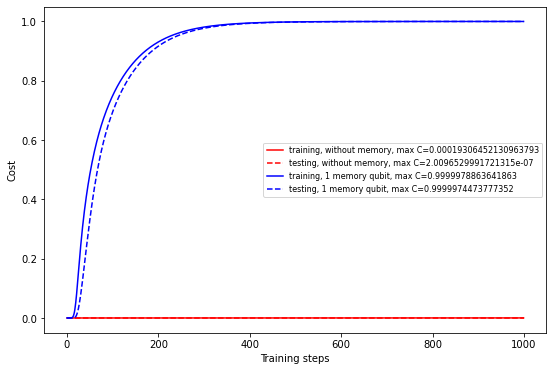

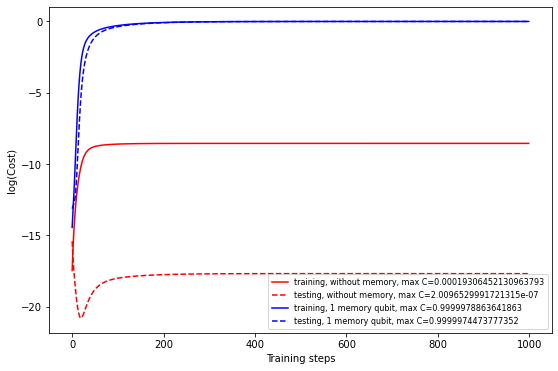

In [26]:
def comparisonplots1memqubit (trainingset,testset,qnnarchwom,learningrate, epsilon, numbertrainingsteps):
    qnnarch1m=qnnarchwom.copy()
    qnnarch1m[0]=qnnarchwom[0]+1
    qnnarch1m[-1]=qnnarchwom[-1]+1
    qnnarch1m.insert(0,1)
    s=[]
    Cwom=[]
    C1m=[]
    Cwomtest=[]
    C1mtest=[]
    logCwom=[]
    logC1m=[]
    logCwomtest=[]
    logC1mtest=[]
    L=len(qnnarchwom)-1
    unitarieswom=randomunitarieswom(qnnarchwom)
    unitaries1m=randomunitaries(qnnarch1m)
    trainingset1m=trainingset
    trainingsetwom=trainingset1m.copy()
    trainingsetwom.pop(0)
    trainingsetwom.pop(-1)
    trainingset1mtest=testset
    trainingsetwomtest=trainingset1mtest.copy()
    trainingsetwomtest.pop(0)
    trainingsetwomtest.pop(-1)
    #namefile="C(s) with etaepsilon="+str(learningrate*epsilon)+",qnnarchwom="+str(qnnarchwom)+",numberoftrainingsteps="+str(numbertrainingsteps)+",N="+str(len(trainingset)-1)
    #dC=pd.DataFrame(data=None,index=None,columns=["N","Cwom","C1m","Cwomtest","C1mtest","logCwom","logC1m","logCwomtest","logC1mtest"])
    for i in range(numbertrainingsteps):
        #feedforward and backward part first wom and then with 1 mem qubit
        rhowom=feedforwardwom(trainingsetwom,unitarieswom,qnnarchwom)
        rhowomtest=feedforwardwom(trainingsetwomtest,unitarieswom,qnnarchwom)
        sigmawom=backwardwom(trainingsetwom, unitarieswom, qnnarchwom)
        rho1m=feedforwardbig(trainingset1m,unitaries1m,qnnarch1m)
        rho1mtest=feedforwardbig(trainingset1mtest,unitaries1m,qnnarch1m)
        omega1m=backwardbig(trainingset1m, unitaries1m, qnnarch1m)
        #lists for plot
        s.append(i*epsilon)
        Cwomi=costbigwom(trainingsetwom,rhowom)
        Cwom.append(Cwomi)
        C1mi=costbig(rho1m)
        C1m.append(C1mi)
        Cwomtesti=costbigwom(trainingsetwomtest,rhowomtest)
        Cwomtest.append(Cwomtesti)
        C1mtesti=costbig(rho1mtest)
        C1mtest.append(C1mtesti)
        logCwomi=np.log(Cwomi)
        logCwom.append(logCwomi)
        logC1mi=np.log(C1mi)
        logC1m.append(logC1mi)
        logCwomtesti=np.log(Cwomtesti)
        logCwomtest.append(logCwomtesti)
        logC1mtesti=np.log(C1mtesti)
        logC1mtest.append(logC1mtesti)
        #dC=dC.append(pd.DataFrame([[i,Cwomi,C1mi,Cwomtesti,C1mtesti,logCwomi,logC1mi,logCwomtesti,logC1mtesti]],columns=dC.columns),ignore_index=True)
        #dC.to_csv("%s.csv" % namefile)
        #calculate update matrices
        updateunitswom=updatematricesbigwom(unitarieswom, trainingsetwom, qnnarchwom,rhowom,sigmawom,learningrate,epsilon)
        updateunits1m=updatematricesbig(unitaries1m, trainingset1m, qnnarch1m,rho1m,omega1m,learningrate/C1mi,epsilon)
        #update unitaries
        for l in range(L):
            for j in range(qnnarchwom[l+1]):
                unitarieswom[l][j]=updateunitswom[l][j]*unitarieswom[l][j]
            for j in range(qnnarch1m[l+2]):
                unitaries1m[l][j]=updateunits1m[l][j]*unitaries1m[l][j]
    Cwommax=max(Cwom)
    C1mmax=max(C1m)
    Cwommaxtest=max(Cwomtest)
    C1mmaxtest=max(C1mtest)
    #plot
    fig1=plt.figure()
    plt.plot(s,Cwom,'r',label="training, without memory, max C="+str(Cwommax))
    plt.plot(s,Cwomtest,'r--',label="testing, without memory, max C="+str(Cwommaxtest))
    plt.plot(s,C1m,'b',label="training, 1 memory qubit, max C="+str(C1mmax))
    plt.plot(s,C1mtest,'b--',label="testing, 1 memory qubit, max C="+str(C1mmaxtest))
    plt.xlabel('Training steps')
    plt.ylabel('Cost')
    plt.legend(loc="best",prop={'size':8})
    #fig1.show()
    fig2=plt.figure()
    plt.plot(s,logCwom,'r',label="training, without memory, max C="+str(Cwommax))
    plt.plot(s,logCwomtest,'r--',label="testing, without memory, max C="+str(Cwommaxtest))
    plt.plot(s,logC1m,'b',label="training, 1 memory qubit, max C="+str(C1mmax))
    plt.plot(s,logC1mtest,'b--',label="testing, 1 memory qubit, max C="+str(C1mmaxtest))
    plt.xlabel('Training steps')
    plt.ylabel('log(Cost)')
    plt.legend(loc="best",prop={'size':8})
    #fig2.show()
trainingsetbig=trainingsetfromswapwithonememqubit (20)
testsetbig=trainingsetfromswapwithonememqubit (20)
comparisonplots1memqubit (trainingsetbig,testsetbig,[1,1],0.005, 1, 1000)